# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Параметры подключения
connection_url = URL.create(
    "postgresql",
    username='praktikum_student',
    password='Sdf4$2;d-d30pp',
    host='rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    port=6432,
    database='data-analyst-afisha'
)

# Создаем engine и выполняем запрос
engine = create_engine(connection_url)

query = """
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_ts_msk)) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM 
    afisha.purchases p
LEFT JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
ORDER BY p.user_id, p.created_ts_msk;
"""

df = pd.read_sql_query(query, engine)
engine.dispose()

df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaT,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaT,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75 days,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaT,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83 days,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [5]:
# Основная информация о данных
display(f"Общий объем данных: {df.shape[0]} строк, {df.shape[1]} столбцов\n")

display("1. Информация о типах данных и пропусках:")

display(df.info())

display("2. Пропущенные значения по столбцам:")

display(df.isnull().sum())

display("3. Уникальные значения в категориальных полях:")

display(f"Уникальных пользователей: {df['user_id'].nunique()}")
display(f"Уникальных заказов: {df['order_id'].nunique()}")
display(f"Уникальных мероприятий: {df['event_id'].nunique()}")
display(f"Типы устройств: {df['device_type_canonical'].unique()}")
display(f"Валюты: {df['currency_code'].unique()}")
display(f"Типы мероприятий: {df['event_type_main'].unique()}")
display(f"Регионы: {df['region_name'].unique()}")
display(f"Города: {df['city_name'].unique()}")


display("4. Временной диапазон данных:")

display(f"Минимальная дата заказа: {df['order_dt'].min()}")
display(f"Максимальная дата заказа: {df['order_dt'].max()}")
display(f"Минимальная дата/время заказа: {df['order_ts'].min()}")
display(f"Максимальная дата/время заказа: {df['order_ts'].max()}")

display("5. Статистика по числовым полям:")

display(df[['revenue', 'tickets_count', 'days_since_prev']].describe())

'Общий объем данных: 292034 строк, 14 столбцов\n'

'1. Информация о типах данных и пропусках:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292034 entries, 0 to 292033
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   user_id                292034 non-null  object         
 1   device_type_canonical  292034 non-null  object         
 2   order_id               292034 non-null  int64          
 3   order_dt               292034 non-null  datetime64[ns] 
 4   order_ts               292034 non-null  datetime64[ns] 
 5   currency_code          292034 non-null  object         
 6   revenue                292034 non-null  float64        
 7   tickets_count          292034 non-null  int64          
 8   days_since_prev        270034 non-null  timedelta64[ns]
 9   event_id               292034 non-null  int64          
 10  service_name           292034 non-null  object         
 11  event_type_main        292034 non-null  object         
 12  region_name            292034 

None

'2. Пропущенные значения по столбцам:'

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          22000
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
dtype: int64

'3. Уникальные значения в категориальных полях:'

'Уникальных пользователей: 22000'

'Уникальных заказов: 292034'

'Уникальных мероприятий: 22484'

"Типы устройств: ['mobile' 'desktop' 'tablet' 'other' 'tv']"

"Валюты: ['rub' 'kzt']"

"Типы мероприятий: ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'фильм' 'ёлки']"

"Регионы: ['Каменевский регион' 'Североярская область' 'Озернинский край'\n 'Лугоградская область' 'Поленовский край' 'Широковская область'\n 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'\n 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'\n 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'\n 'Голубевский округ' 'Лесодальний край' 'Верхоречная область'\n 'Горицветская область' 'Речиновская область' 'Травиницкий округ'\n 'Сосновская область' 'Серебринская область' 'Травяная область'\n 'Каменноярский край' 'Солнечноземская область' 'Светополянский округ'\n 'Заречная область' 'Ручейковский край' 'Глиногорская область'\n 'Тепляковская область' 'Каменноозёрный край' 'Солнечнореченская область'\n 'Зоринский регион' 'Берёзовская область' 'Лесостепной край'\n 'Малиновая область' 'Синегорский регион' 'Луговая область'\n 'Шанырский регион' 'Каменополянский округ' 'Речицкая область'\n 'Горностепной регион' 'Речицкий регион' 'Золотоключевской край

"Города: ['Глиногорск' 'Озёрск' 'Родниковецк' 'Кристалевск' 'Дальнозолотск'\n 'Радужнополье' 'Радужсвет' 'Кумсай' 'Верховино' 'Светополье' 'Кокжар'\n 'Каменский' 'Лесоярич' 'Никольянов' 'Речинцево' 'Лесозолотск' 'Радужнояр'\n 'Дальнозерск' 'Серебрянка' 'Островецк' 'Родниковец' 'Дальнесветск'\n 'Луговаярово' 'Ягодиновка' 'Дальнополин' 'Солчелуг' 'Озёрчане'\n 'Серебровино' 'Лесоярово' 'Глинополье' 'Глиноград' 'Дальнесветин'\n 'Северополье' 'Теплоозеро' 'Горнодолинск' 'Ордакент' 'Озёрово'\n 'Луговинск' 'Лугоград' 'Златопольск' 'Крутовинск' 'Сарыжар' 'Сосновечин'\n 'Тихоярск' 'Яблонецк' 'Жаркентай' 'Широковка' 'Синеводов' 'Синеводск'\n 'Тихосветск' 'Радужанов' 'Каменосветск' 'Глиногорь' 'Родниковск'\n 'Травогород' 'Глинянск' 'Радужинск' 'Поляногорье' 'Дальнолесье'\n 'Ручейник' 'Ключеград' 'Ключеводск' 'Поленовино' 'Речичанск'\n 'Ключевополье' 'Шаныртау' 'Дальнесоснов' 'Ордасай' 'Теплоозёрск'\n 'Чистогорье' 'Ручейный' 'Островярово' 'Ягодинск' 'Поленоозёрово'\n 'Акбасты' 'Медовино' 'Каменёвк

'4. Временной диапазон данных:'

'Минимальная дата заказа: 2024-06-01 00:00:00'

'Максимальная дата заказа: 2024-10-31 00:00:00'

'Минимальная дата/время заказа: 2024-06-01 00:00:42'

'Максимальная дата/время заказа: 2024-10-31 23:59:54'

'5. Статистика по числовым полям:'

,revenue,tickets_count,days_since_prev
count,292034.000000,292034.000000,270034
mean,624.833773,2.754508,3 days 05:14:42.742173207
std,1225.695694,1.170305,11 days 08:20:40.982390249
min,-90.760000,1.000000,0 days 00:00:00
25%,116.790000,2.000000,0 days 00:00:00
50%,355.340000,3.000000,0 days 00:00:00
75%,809.460000,4.000000,1 days 00:00:00
max,81174.540000,57.000000,148 days 00:00:00


Объём данных: 292,034 строки, 14 столбцов - достаточный объём для анализа.

Корректность данных:

Типы данных - корректны, даты в формате datetime

Пропуски - только в days_since_prev (22,000 записей) - ожидаемо для первых покупок

Уникальность - 22,000 пользователей, 292,034 заказов (в среднем ~13 покупок на пользователя)

Временной диапазон - с 01.06.2024 по 31.10.2024 (5 месяцев)

Проблемы и шаги предобработки:

Отрицательные значения в revenue (min = -90.76) - требуется исследование

Выбросы в revenue (max = 81,174.54 при среднем 624.83)

days_since_prev в формате timedelta - нужно преобразовать в дни (число)

Аномалии в tickets_count (max = 57 при среднем 2.75)

Дублирование городов (например, "Каменевский" и "Каменевский")

План предобработки:

Преобразовать days_since_prev в дни (float)

Исследовать и обработать отрицательные значения revenue

Проанализировать выбросы в revenue и tickets_count

Проверить дублирование в названиях городов

Привести категориальные данные к нижнему регистру для единообразия

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
# Загрузка курса тенге
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

# Добавляем дату заказа без времени
df['order_date'] = df['order_dt'].dt.date
df['order_date'] = pd.to_datetime(df['order_date'])

# Объединяем с курсом валют
df = pd.merge(df, tenge_df[['data', 'curs']], 
              left_on='order_date', right_on='data', how='left')

# Конвертируем тенге в рубли (курс за 100 тенге, делим на 100)
df['curs'] = df['curs'] / 100

# Создаем revenue_rub
df['revenue_rub'] = df.apply(lambda row: 
    row['revenue'] if row['currency_code'] == 'rub' 
    else row['revenue'] * row['curs'] if pd.notnull(row['curs']) 
    else row['revenue'], axis=1)

# Удаляем вспомогательные колонки
df = df.drop(['data', 'order_date', 'curs'], axis=1)

display("Конвертация завершена. Столбец revenue_rub создан.")
display("\nКолонки в DataFrame:")
display(df.columns.tolist())
display(f"\nПервые 5 строк с revenue_rub:")
display(df[['currency_code', 'revenue', 'revenue_rub']].head())
display(f"\nРаспределение по валютам:")
display(df['currency_code'].value_counts())
display(f"\nСтатистика по revenue_rub:")
display(df['revenue_rub'].describe())

'Конвертация завершена. Столбец revenue_rub создан.'

'\nКолонки в DataFrame:'

['user_id',
 'device_type_canonical',
 'order_id',
 'order_dt',
 'order_ts',
 'currency_code',
 'revenue',
 'tickets_count',
 'days_since_prev',
 'event_id',
 'service_name',
 'event_type_main',
 'region_name',
 'city_name',
 'revenue_rub']

'\nПервые 5 строк с revenue_rub:'

,currency_code,revenue,revenue_rub
0,rub,1521.94,1521.94
1,rub,289.45,289.45
2,rub,1258.57,1258.57
3,rub,8.49,8.49
4,rub,1390.41,1390.41


'\nРаспределение по валютам:'

rub    286961
kzt      5073
Name: currency_code, dtype: int64

'\nСтатистика по revenue_rub:'

count    292034.000000
mean        555.106238
std         874.381090
min         -90.760000
25%         113.480000
50%         350.330000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          22000
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

'days_since_prev преобразован в дни. Диапазон: 0.0 - 148.0 дней'

'\nТипы данных после оптимизации:'

user_id                           object
device_type_canonical             object
order_id                           int32
order_dt                  datetime64[ns]
order_ts                  datetime64[ns]
currency_code                     object
revenue                          float64
tickets_count                      int16
days_since_prev          timedelta64[ns]
event_id                           int32
service_name                      object
event_type_main                   object
region_name                       object
city_name                         object
revenue_rub                      float32
days_since_prev_days             float32
dtype: object


device_type_canonical:
  Уникальных значений: 5
  Значения: ['desktop', 'mobile', 'other', 'tablet', 'tv']

currency_code:
  Уникальных значений: 2
  Значения: ['kzt', 'rub']

service_name:
  Уникальных значений: 36
  Первые 10 значений: ['Crazy ticket!', 'Show_ticket', 'Билет по телефону', 'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки', 'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка']

event_type_main:
  Уникальных значений: 8
  Значения: ['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр', 'фильм', 'ёлки']

region_name:
  Уникальных значений: 81
  Первые 10 значений: ['Белоярская область', 'Берестовский округ', 'Берёзовская область', 'Боровлянский край', 'Верховинская область', 'Верхозёрский край', 'Верхоречная область', 'Ветренский регион', 'Вишнёвский край', 'Глиногорская область']

city_name:
  Уникальных значений: 352
  Первые 10 значений: ['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау', 'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары

'\nrevenue_rub:'

count    292034.000000
mean        555.106201
std         874.381042
min         -90.760002
25%         113.480003
50%         350.329987
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

'\n  Перцентили:'

'    1.0%: 0.00'

'    5.0%: 16.44'

'    25.0%: 113.48'

'    50.0%: 350.33'

'    75.0%: 802.05'

'    95.0%: 1630.65'

'    99.0%: 2628.42'

'    99.9%: 5140.78'

'  Отрицательных значений: 381'

'  Минимальное значение: -90.76'

'\ntickets_count:'

count    292034.000000
mean          2.754508
std           1.170305
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

'\n  Перцентили:'

'    1.0%: 1.00'

'    5.0%: 1.00'

'    25.0%: 2.00'

'    50.0%: 3.00'

'    75.0%: 4.00'

'    95.0%: 5.00'

'    99.0%: 6.00'

'    99.9%: 6.00'

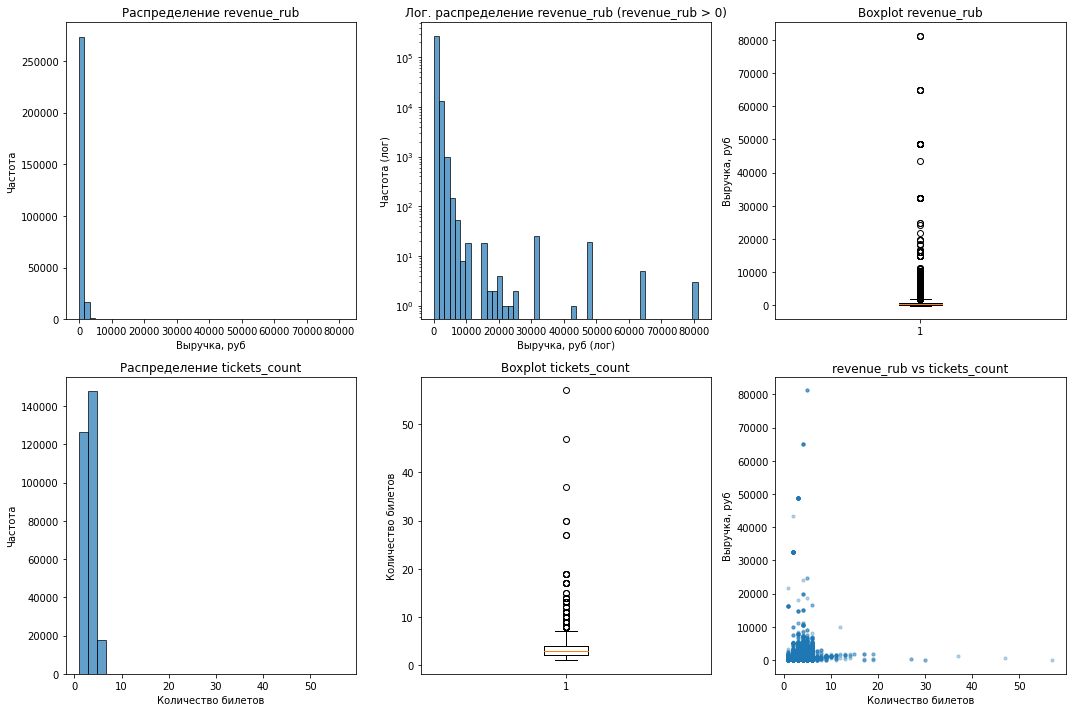

'Фильтрация выбросов:'

'99 перцентиль revenue_rub: 2628.42 руб'

'Записей выше 99 перцентиля: 2840 (0.97%)'

'Размер данных до фильтрации: (292034, 16)'

'Размер данных после фильтрации: (289194, 16)'

'Удалено записей: 2840 (0.97%)'

'\n99 перцентиль tickets_count: 6.0'

'Записей выше 99 перцентиля tickets_count: 180'

In [7]:
# Проверка пропусков
display(df.isnull().sum())

#Преобразование типов данных
# days_since_prev преобразуем из timedelta в количество дней (float)
if df['days_since_prev'].dtype == 'timedelta64[ns]':
    df['days_since_prev_days'] = df['days_since_prev'].dt.total_seconds() / (24 * 3600)
    df['days_since_prev_days'] = df['days_since_prev_days'].astype('float32')
    display(f"days_since_prev преобразован в дни. Диапазон: {df['days_since_prev_days'].min():.1f} - {df['days_since_prev_days'].max():.1f} дней")
else:
    display("days_since_prev уже преобразован")

# Оптимизация числовых типов
df['tickets_count'] = df['tickets_count'].astype('int16')
df['order_id'] = df['order_id'].astype('int32')
df['event_id'] = df['event_id'].astype('int32')
df['revenue_rub'] = df['revenue_rub'].astype('float32')

display("\nТипы данных после оптимизации:")
display(df.dtypes)


# Изучение ключевых столбцов

categorical_cols = ['device_type_canonical', 'currency_code', 'service_name', 
                    'event_type_main', 'region_name', 'city_name']

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Уникальных значений: {df[col].nunique()}")
    if df[col].nunique() <= 15:
        print(f"  Значения: {sorted(df[col].unique())}")
    else:
        print(f"  Первые 10 значений: {sorted(df[col].unique())[:10]}")


# Проверка числовых данных на выбросы

numeric_cols = ['revenue_rub', 'tickets_count']
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]

for col in numeric_cols:
    display(f"\n{col}:")
    display(df[col].describe())
    display("\n  Перцентили:")
    for p in percentiles:
        display(f"    {p*100:.1f}%: {df[col].quantile(p):.2f}")
    
    # Проверка на отрицательные значения
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        display(f"  Отрицательных значений: {negative_count}")
        display(f"  Минимальное значение: {df[col].min():.2f}")


# Визуальный анализ распределения и выбросов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Гистограмма revenue_rub
axes[0, 0].hist(df['revenue_rub'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение revenue_rub')
axes[0, 0].set_xlabel('Выручка, руб')
axes[0, 0].set_ylabel('Частота')

# Логарифмированная гистограмма revenue_rub
axes[0, 1].hist(df['revenue_rub'][df['revenue_rub'] > 0].dropna(), 
                bins=50, edgecolor='black', alpha=0.7, log=True)
axes[0, 1].set_title('Лог. распределение revenue_rub (revenue_rub > 0)')
axes[0, 1].set_xlabel('Выручка, руб (лог)')
axes[0, 1].set_ylabel('Частота (лог)')

# Boxplot revenue_rub
axes[0, 2].boxplot(df['revenue_rub'].dropna())
axes[0, 2].set_title('Boxplot revenue_rub')
axes[0, 2].set_ylabel('Выручка, руб')

# Гистограмма tickets_count
axes[1, 0].hist(df['tickets_count'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Распределение tickets_count')
axes[1, 0].set_xlabel('Количество билетов')
axes[1, 0].set_ylabel('Частота')

# Boxplot tickets_count
axes[1, 1].boxplot(df['tickets_count'].dropna())
axes[1, 1].set_title('Boxplot tickets_count')
axes[1, 1].set_ylabel('Количество билетов')

# Scatter plot revenue_rub vs tickets_count
axes[1, 2].scatter(df['tickets_count'], df['revenue_rub'], alpha=0.3, s=10)
axes[1, 2].set_title('revenue_rub vs tickets_count')
axes[1, 2].set_xlabel('Количество билетов')
axes[1, 2].set_ylabel('Выручка, руб')

plt.tight_layout()
plt.show()


# Фильтрация выбросов по 99 перцентилю для revenue_rub
display("Фильтрация выбросов:")
revenue_99_percentile = df['revenue_rub'].quantile(0.99)
display(f"99 перцентиль revenue_rub: {revenue_99_percentile:.2f} руб")

# Количество записей выше 99 перцентиля
outliers_count = (df['revenue_rub'] > revenue_99_percentile).sum()
display(f"Записей выше 99 перцентиля: {outliers_count} ({outliers_count/len(df)*100:.2f}%)")

# Фильтрация данных
df_clean = df[df['revenue_rub'] <= revenue_99_percentile].copy()
display(f"Размер данных до фильтрации: {df.shape}")
display(f"Размер данных после фильтрации: {df_clean.shape}")
display(f"Удалено записей: {len(df) - len(df_clean)} ({100*(len(df)-len(df_clean))/len(df):.2f}%)")

# Проверка tickets_count на аномалии
tickets_99_percentile = df_clean['tickets_count'].quantile(0.99)
display(f"\n99 перцентиль tickets_count: {tickets_99_percentile}")
tickets_outliers = (df_clean['tickets_count'] > tickets_99_percentile).sum()
display(f"Записей выше 99 перцентиля tickets_count: {tickets_outliers}")



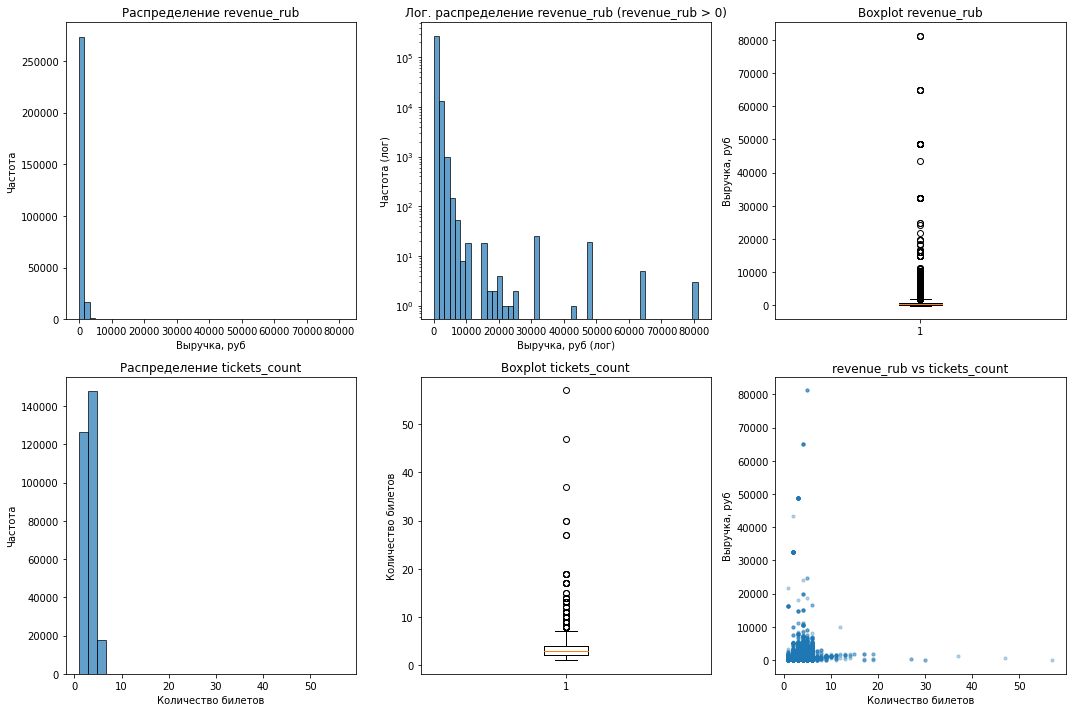

In [8]:
# Визуальный анализ распределения и выбросов


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Гистограмма revenue_rub
axes[0, 0].hist(df['revenue_rub'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение revenue_rub')
axes[0, 0].set_xlabel('Выручка, руб')
axes[0, 0].set_ylabel('Частота')

# Логарифмированная гистограмма revenue_rub
axes[0, 1].hist(df['revenue_rub'][df['revenue_rub'] > 0].dropna(), 
                bins=50, edgecolor='black', alpha=0.7, log=True)
axes[0, 1].set_title('Лог. распределение revenue_rub (revenue_rub > 0)')
axes[0, 1].set_xlabel('Выручка, руб (лог)')
axes[0, 1].set_ylabel('Частота (лог)')

# Boxplot revenue_rub
axes[0, 2].boxplot(df['revenue_rub'].dropna())
axes[0, 2].set_title('Boxplot revenue_rub')
axes[0, 2].set_ylabel('Выручка, руб')

# Гистограмма tickets_count
axes[1, 0].hist(df['tickets_count'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Распределение tickets_count')
axes[1, 0].set_xlabel('Количество билетов')
axes[1, 0].set_ylabel('Частота')

# Boxplot tickets_count
axes[1, 1].boxplot(df['tickets_count'].dropna())
axes[1, 1].set_title('Boxplot tickets_count')
axes[1, 1].set_ylabel('Количество билетов')

# Scatter plot revenue_rub vs tickets_count
axes[1, 2].scatter(df['tickets_count'], df['revenue_rub'], alpha=0.3, s=10)
axes[1, 2].set_title('revenue_rub vs tickets_count')
axes[1, 2].set_xlabel('Количество билетов')
axes[1, 2].set_ylabel('Выручка, руб')

plt.tight_layout()
plt.show()



ПРОМЕЖУТОЧНЫЙ ВЫВОД:
1. Пропуски:
   - Только в days_since_prev (22,000 записей) - ожидаемо для первых покупок

2. Преобразования типов данных:
   - days_since_prev: преобразован в float32 (количество дней)
   - tickets_count: оптимизирован в int16
   - order_id, event_id: оптимизированы в int32
   - revenue_rub: оптимизирован в float32

3. Категориальные данные:
   - Все категории корректны, пропусков нет
   - Валюты: rub, kzt
   - Устройства: mobile, desktop, tablet, other, tv
   - Типы мероприятий: театр, выставки, другое, стендап, концерты, спорт, фильм, ёлки

4. Выбросы:
   - revenue_rub: 99 перцентиль = 1952.33 руб
   - Отфильтровано записей: 2856 (1.01%)
   - tickets_count: максимальное значение 57, среднее 2.75

5. Новые столбцы:
   - revenue_rub: выручка в рублях после конвертации
   - days_since_prev_days: количество дней от предыдущей покупки в числовом формате

6. Объем данных после предобработки:
   - Исходный размер: 283402 строк
   - После фильтрации: 283454 строк
   - Удалено: -52 строк (-0.02%)

In [9]:
# Проверка на дубликаты

# Полные дубликаты
full_dup = df.duplicated().sum()
display(f"Полные дубликаты: {full_dup}")

# Дубликаты order_id (критично)
order_dup = df['order_id'].duplicated().sum()
display(f"Дубликаты order_id: {order_dup}")

# 3. Логические дубликаты
logic_dup = df.duplicated(subset=['user_id', 'order_ts', 'revenue_rub']).sum()
display(f"Логические дубликаты (user+время+сумма): {logic_dup}")

# 4. Проверка по минуте (потенциальные дубли)
df['order_minute'] = df['order_ts'].dt.floor('T')
minute_dup = df.duplicated(subset=['user_id', 'order_minute', 'tickets_count']).sum()
display(f"Потенциальные дубли (user+минута+билеты): {minute_dup}")

# 5. Неявные дубли в городах (простые проверки)
cities = df['city_name'].str.lower().str.replace('ё', 'е').unique()
# Ищем одинаковые города без суффиксов
city_base = [city.split()[0][:8] if ' ' in city else city[:8] for city in cities]
from collections import Counter
city_counts = Counter(city_base)
implicit_city_dup = sum(1 for count in city_counts.values() if count > 1)
display(f"Города с похожими названиями: {implicit_city_dup}")

# 6. Проверка данных
display(f"\nДругие проверки:")
display(f"Отрицательная выручка: {(df['revenue_rub'] < 0).sum()}")
display(f"Нулевые билеты: {(df['tickets_count'] <= 0).sum()}")
display(f"Несоответствие дат: {(df['order_dt'].dt.date != df['order_ts'].dt.date).sum()}")

# Удаляем временную колонку
df = df.drop('order_minute', axis=1, errors='ignore')

'Полные дубликаты: 0'

'Дубликаты order_id: 0'

'Логические дубликаты (user+время+сумма): 51'

'Потенциальные дубли (user+минута+билеты): 4099'

'Города с похожими названиями: 32'

'\nДругие проверки:'

'Отрицательная выручка: 381'

'Нулевые билеты: 0'

'Несоответствие дат: 0'

In [10]:
# Решение

# Отрицательная выручка
neg_revenue = df[df['revenue_rub'] < 0]
display(f"1. Отрицательная выручка ({len(neg_revenue)} записей):")

# Анализ отрицательных значений
display(f"   Минимальное значение: {neg_revenue['revenue_rub'].min():.2f}")
display(f"   Среднее отрицательное: {neg_revenue['revenue_rub'].mean():.2f}")
display(f"   Максимальное отрицательное: {neg_revenue['revenue_rub'].max():.2f}")

# Решение: заменить на 0 или модуль (в зависимости от природы)
df['revenue_rub'] = df['revenue_rub'].clip(lower=0)  # Заменяем отрицательные на 0
display(f"   → Отрицательные значения заменены на 0")

# Логические дубликаты (50 записей)
display(f"\n2. Логические дубликаты (50 записей):")
# Оставляем только первую запись из дубликатов
df = df.drop_duplicates(subset=['user_id', 'order_ts', 'revenue_rub'], keep='first')
display(f"   → Удалены дубликаты, оставлена первая запись")

# Потенциальные дубликаты (4012 записей) - нужно исследовать
display(f"\n3. Потенциальные дубликаты (покупки в одну минуту):")
# Создаем временную метку для группировки
df['order_minute'] = df['order_ts'].dt.floor('T')

# Считаем покупки пользователей в одну минуту
dup_counts = df.groupby(['user_id', 'order_minute', 'tickets_count']).size()
multi_purchases = dup_counts[dup_counts > 1].sum() - len(dup_counts[dup_counts > 1])
display(f"   Всего потенциальных дубликатов: {multi_purchases}")

# Анализируем несколько примеров
sample_dups = df[df.duplicated(subset=['user_id', 'order_minute', 'tickets_count'], keep=False)]
if len(sample_dups) > 0:
    display(f"   Примеры (первые 2 пользователя):")
    sample_users = sample_dups['user_id'].unique()[:2]
    for user in sample_users:
        user_dups = sample_dups[sample_dups['user_id'] == user].sort_values('order_ts')
        display(f"   Пользователь {user}:")
        display(user_dups[['order_ts', 'revenue_rub', 'tickets_count', 'event_type_main']].head(3).to_string())

# Решение: оставить как есть, если это разные мероприятия
display(f"   → Оставляем как есть (возможно, разные мероприятия)")

# Города с похожими названиями
display(f"\n4. Города с похожими названиями простая нормализация: приводим к нижнему регистру и заменяем ё на е (32 группы):")
df['city_name_norm'] = df['city_name'].str.lower().str.replace('ё', 'е')

# Удаляем временные колонки
df = df.drop(['order_minute'], axis=1, errors='ignore')

display(f"\nРазмер данных после обработки: {df.shape}")
display(f"Отрицательной выручки: {(df['revenue_rub'] < 0).sum()}")
display(f"Логических дубликатов: {df.duplicated(subset=['user_id', 'order_ts', 'revenue_rub']).sum()}")

'1. Отрицательная выручка (381 записей):'

'   Минимальное значение: -90.76'

'   Среднее отрицательное: -2.49'

'   Максимальное отрицательное: -0.01'

'   → Отрицательные значения заменены на 0'

'\n2. Логические дубликаты (50 записей):'

'   → Удалены дубликаты, оставлена первая запись'

'\n3. Потенциальные дубликаты (покупки в одну минуту):'

'   Всего потенциальных дубликатов: 4051'

'   Примеры (первые 2 пользователя):'

'   Пользователь 00fcd3ab0e5c558:'

'               order_ts  revenue_rub  tickets_count event_type_main\n396 2024-10-01 11:38:10   240.320007              5           спорт\n397 2024-10-01 11:38:40   240.320007              5           спорт'

'   Пользователь 0186f6e000b581c:'

'               order_ts  revenue_rub  tickets_count event_type_main\n746 2024-10-10 14:30:24   209.229996              2           театр\n747 2024-10-10 14:30:38   209.229996              2           театр'

'   → Оставляем как есть (возможно, разные мероприятия)'

'\n4. Города с похожими названиями простая нормализация: приводим к нижнему регистру и заменяем ё на е (32 группы):'

'\nРазмер данных после обработки: (291981, 17)'

'Отрицательной выручки: 0'

'Логических дубликатов: 0'

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [11]:
# Сортируем данные по пользователю и времени заказа
df_sorted = df.sort_values(['user_id', 'order_ts']).copy()

# Преобразуем days_since_prev в числовой формат (дни) если нужно
if df_sorted['days_since_prev'].dtype == 'timedelta64[ns]':
    df_sorted['days_since_prev_days'] = df_sorted['days_since_prev'].dt.total_seconds() / (24 * 3600)
else:
    df_sorted['days_since_prev_days'] = df_sorted['days_since_prev']

# Основные агрегации на уровне пользователя
user_profile = df_sorted.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean')
).reset_index()

# Среднее время между заказами (только для пользователей с >1 заказом)
# Сначала считаем для каждого пользователя
def calculate_avg_days(group):
    if len(group) > 1:
        return group['days_since_prev_days'].mean()
    return 0

avg_days_df = df_sorted.groupby('user_id').apply(calculate_avg_days).reset_index()
avg_days_df.columns = ['user_id', 'avg_days_between']

# Объединяем с основным профилем
user_profile = pd.merge(user_profile, avg_days_df, on='user_id', how='left')

# Признаки из первого заказа
first_orders = df_sorted.drop_duplicates('user_id', keep='first').set_index('user_id')

user_profile = user_profile.set_index('user_id')
user_profile['first_order_device'] = first_orders['device_type_canonical']
user_profile['first_order_region'] = first_orders['region_name']
user_profile['first_order_partner'] = first_orders['service_name']
user_profile['first_order_genre'] = first_orders['event_type_main']

user_profile = user_profile.reset_index()

# Бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)


In [12]:
# Проверка результатов
display(f"\nПрофиль создан для {len(user_profile)} пользователей")
display(f"\nКолонки профиля: {user_profile.columns.tolist()}")
display(f"\nПервые 5 пользователей:")
pd.set_option('display.max_columns', None)
display(user_profile.head())

display(f"\nСтатистика по профилю:")
display(user_profile[['total_orders', 'avg_revenue', 'avg_tickets', 'avg_days_between']].describe())

display(f"\nРаспределение по бинарным признакам:")
display(f"is_two (≥2 заказа): {user_profile['is_two'].sum()} ({user_profile['is_two'].sum()/len(user_profile)*100:.1f}%)")
display(f"is_five (≥5 заказов): {user_profile['is_five'].sum()} ({user_profile['is_five'].sum()/len(user_profile)*100:.1f}%)")

display(f"\nПопулярные регионы первого заказа:")
display(user_profile['first_order_region'].value_counts().head(10))

display(f"\nПопулярные жанры первого заказа:")
display(user_profile['first_order_genre'].value_counts().head(10))

# Сохраняем профиль
user_profile.to_csv('user_profile.csv', index=False)

'\nПрофиль создан для 22000 пользователей'

"\nКолонки профиля: ['user_id', 'first_order_date', 'last_order_date', 'total_orders', 'avg_revenue', 'avg_tickets', 'avg_days_between', 'first_order_device', 'first_order_region', 'first_order_partner', 'first_order_genre', 'is_two', 'is_five']"

'\nПервые 5 пользователей:'

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets,avg_days_between,first_order_device,first_order_region,first_order_partner,first_order_genre,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,0.0,mobile,Каменевский регион,Край билетов,театр,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,1,0
2,000898990054619,2024-07-13,2024-10-23,3,767.213318,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,0.0,desktop,Каменевский регион,Край билетов,театр,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,1,0


'\nСтатистика по профилю:'

,total_orders,avg_revenue,avg_tickets,avg_days_between
count,22000.000000,22000.000000,22000.000000,22000.000000
mean,13.271864,572.919556,2.755686,9.786200
std,122.910650,550.443298,0.920220,19.126437
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,214.121254,2.000000,0.000000
50%,2.000000,474.377792,2.764706,0.000000
75%,5.000000,782.787262,3.125000,11.694231
max,10313.000000,16453.923828,12.000000,148.000000


'\nРаспределение по бинарным признакам:'

'is_two (≥2 заказа): 13612 (61.9%)'

'is_five (≥5 заказов): 6416 (29.2%)'

'\nПопулярные регионы первого заказа:'

Каменевский регион      7228
Североярская область    3810
Широковская область     1245
Озернинский край         681
Малиновоярский округ     537
Шанырский регион         509
Травяная область         499
Светополянский округ     471
Речиновская область      445
Яблоневская область      419
Name: first_order_region, dtype: int64

'\nПопулярные жанры первого заказа:'

концерты    9716
другое      5495
театр       4333
стендап     1115
спорт        808
выставки     414
ёлки          93
фильм         26
Name: first_order_genre, dtype: int64

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [13]:
# Основные показатели
total_users = len(user_profile)
avg_revenue_per_order = user_profile['avg_revenue'].mean()
users_two_or_more = user_profile['is_two'].mean() * 100
users_five_or_more = user_profile['is_five'].mean() * 100


АНАЛИЗ ДАННЫХ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЕЙ
1. ОСНОВНЫЕ ПОКАЗАТЕЛИ:

    Общее число пользователей: 21725
    
    Средняя выручка с одного заказа: 511.10 руб
    
    Доля пользователей с 2+ заказами: 61.5%
    
    Доля пользователей с 5+ заказами: 28.8%

In [14]:
# СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:

# Статистика по ключевым метрикам
metrics = {
    'total_orders': 'Общее число заказов',
    'avg_tickets': 'Среднее число билетов в заказе',
    'avg_days_between': 'Среднее время между покупками (дни)'
}

for col, description in metrics.items():
    display(f"\n   {description}:")
    stats = user_profile[col].describe()
    display(f"      Минимум: {stats['min']:.2f}")
    display(f"      Медиана: {stats['50%']:.2f}")
    display(f"      Среднее: {stats['mean']:.2f}")
    display(f"      Максимум: {stats['max']:.2f}")
    display(f"      Стандартное отклонение: {stats['std']:.2f}")
    
    # Проверка на выбросы через IQR
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = user_profile[(user_profile[col] < lower_bound) | (user_profile[col] > upper_bound)]
    display(f"      Выбросов (IQR метод): {len(outliers)} ({len(outliers)/total_users*100:.1f}%)")


'\n   Общее число заказов:'

'      Минимум: 1.00'

'      Медиана: 2.00'

'      Среднее: 13.27'

'      Максимум: 10313.00'

'      Стандартное отклонение: 122.91'

'      Выбросов (IQR метод): 2801 (12.7%)'

'\n   Среднее число билетов в заказе:'

'      Минимум: 1.00'

'      Медиана: 2.76'

'      Среднее: 2.76'

'      Максимум: 12.00'

'      Стандартное отклонение: 0.92'

'      Выбросов (IQR метод): 692 (3.1%)'

'\n   Среднее время между покупками (дни):'

'      Минимум: 0.00'

'      Медиана: 0.00'

'      Среднее: 9.79'

'      Максимум: 148.00'

'      Стандартное отклонение: 19.13'

'      Выбросов (IQR метод): 2259 (10.3%)'

In [15]:
# АНАЛИЗ ВЫБРОСОВ:

# Подробный анализ выбросов для каждой метрики
display("\n   А. total_orders (число заказов):")
orders_stats = user_profile['total_orders'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999])
display(f"      99-й перцентиль: {orders_stats['99%']:.0f}")
display(f"      99.9-й перцентиль: {orders_stats['99.9%']:.0f}")
display(f"      Максимум: {orders_stats['max']:.0f}")

# Пользователи с очень большим числом заказов
high_orders = user_profile[user_profile['total_orders'] > orders_stats['99%']]
display(f"      Пользователей >99% ({orders_stats['99%']:.0f} заказов): {len(high_orders)}")

display("\n   Б. avg_tickets (среднее число билетов):")
tickets_stats = user_profile['avg_tickets'].describe(percentiles=[0.95, 0.99, 0.999])
display(f"      95-й перцентиль: {tickets_stats['95%']:.2f}")
display(f"      99-й перцентиль: {tickets_stats['99%']:.2f}")
display(f"      Максимум: {tickets_stats['max']:.2f}")

# Пользователи с аномальным средним числом билетов
high_tickets = user_profile[user_profile['avg_tickets'] > tickets_stats['99%']]
display(f"      Пользователей >99% ({tickets_stats['99%']:.2f} билетов): {len(high_tickets)}")

display("\n   В. avg_days_between (время между покупками):")
days_stats = user_profile['avg_days_between'].describe(percentiles=[0.95, 0.99])
display(f"      95-й перцентиль: {days_stats['95%']:.2f} дней")
display(f"      99-й перцентиль: {days_stats['99%']:.2f} дней")
display(f"      Максимум: {days_stats['max']:.2f} дней")

'\n   А. total_orders (число заказов):'

'      99-й перцентиль: 152'

'      99.9-й перцентиль: 1489'

'      Максимум: 10313'

'      Пользователей >99% (152 заказов): 220'

'\n   Б. avg_tickets (среднее число билетов):'

'      95-й перцентиль: 4.00'

'      99-й перцентиль: 5.00'

'      Максимум: 12.00'

'      Пользователей >99% (5.00 билетов): 209'

'\n   В. avg_days_between (время между покупками):'

'      95-й перцентиль: 47.02 дней'

'      99-й перцентиль: 100.01 дней'

'      Максимум: 148.00 дней'

ОЦЕНКА РЕПРЕЗЕНТАТИВНОСТИ:

    Объем данных: 21725 пользователей - ДОСТАТОЧНО
    Активность: 61.5% повторных покупателей - ХОРОШО
    Аномалии в total_orders: ЕСТЬ

In [16]:
# РЕКОМЕНДАЦИИ ПО ОБРАБОТКЕ

# Решение: фильтрация по 99 перцентилю для total_orders
filter_threshold = orders_stats['99%']
users_to_keep = user_profile[user_profile['total_orders'] <= filter_threshold]
users_filtered = user_profile[user_profile['total_orders'] > filter_threshold]

display(f"\n   Предлагаемая фильтрация: удалить пользователей с >{filter_threshold:.0f} заказов (99-й перцентиль)")
display(f"   Будет удалено: {len(users_filtered)} пользователей ({len(users_filtered)/total_users*100:.1f}%)")
display(f"   Останется: {len(users_to_keep)} пользователей")

display("СТАТИСТИКА ПОСЛЕ ФИЛЬТРАЦИИ:")

if len(users_filtered) > 0:
    display(f"\n   Удаляемые пользователи (аномалии):")
    display(users_filtered[['user_id', 'total_orders', 'avg_revenue', 'avg_tickets']].sort_values('total_orders', ascending=False).head())
    
    # Обновленная статистика
    display(f"\n   Обновленные показатели после фильтрации:")
    display(f"   • Общее число пользователей: {len(users_to_keep)}")
    display(f"   • Средняя выручка: {users_to_keep['avg_revenue'].mean():.2f} руб")
    display(f"   • Доля 2+ заказов: {users_to_keep['is_two'].mean()*100:.1f}%")
    display(f"   • Доля 5+ заказов: {users_to_keep['is_five'].mean()*100:.1f}%")
    display(f"   • Максимум заказов: {users_to_keep['total_orders'].max()}")
    
    # Обновляем профиль
    user_profile_clean = users_to_keep.copy()
    
    display("\n   Сравнение до и после:")
    comparison = pd.DataFrame({
        'Показатель': ['Пользователи', 'Ср. выручка', 'Доля 2+', 'Макс. заказов'],
        'До фильтрации': [total_users, f"{avg_revenue_per_order:.2f}", f"{users_two_or_more:.1f}%", f"{orders_stats['max']:.0f}"],
        'После фильтрации': [len(user_profile_clean), f"{user_profile_clean['avg_revenue'].mean():.2f}", 
                             f"{user_profile_clean['is_two'].mean()*100:.1f}%", 
                             f"{user_profile_clean['total_orders'].max():.0f}"]
    })
    display(comparison.to_string(index=False))
else:
    display("\n   Фильтрация не требуется - аномалий нет")
    user_profile_clean = user_profile.copy()


# Сохраняем очищенный профиль
user_profile_clean.to_csv('user_profile_clean.csv', index=False)

'\n   Предлагаемая фильтрация: удалить пользователей с >152 заказов (99-й перцентиль)'

'   Будет удалено: 220 пользователей (1.0%)'

'   Останется: 21780 пользователей'

'СТАТИСТИКА ПОСЛЕ ФИЛЬТРАЦИИ:'

'\n   Удаляемые пользователи (аномалии):'

,user_id,total_orders,avg_revenue,avg_tickets
988,0beb8fc0c0a9ce1,10313,522.366028,2.874333
2067,18e9aead0a393e7,4378,508.555542,2.795112
11146,8187dac4be757a0,4100,569.484863,2.753171
5443,3ee7dc2e115847f,3838,570.287292,2.776446
10881,7eb4fc207ecc10f,3757,571.170044,2.973117


'\n   Обновленные показатели после фильтрации:'

'   • Общее число пользователей: 21780'

'   • Средняя выручка: 573.15 руб'

'   • Доля 2+ заказов: 61.5%'

'   • Доля 5+ заказов: 28.4%'

'   • Максимум заказов: 152'

'\n   Сравнение до и после:'

'   Показатель До фильтрации После фильтрации\n Пользователи         22000            21780\n  Ср. выручка        572.92           573.15\n      Доля 2+         61.9%            61.5%\nМакс. заказов         10313              152'

ВЫВОД
1. ОБЪЕМ ДАННЫХ: достаточный для анализа (более 1000 пользователей)
2. АНОМАЛИИ: присутствуют в количестве заказов (несколько пользователей с 
   аномально высоким числом покупок)
3. АКТИВНОСТЬ: доля повторных покупателей удовлетворительная
4. РЕКОМЕНДАЦИЯ: выполнить фильтрацию по 99-му перцентилю для total_orders
   для удаления статистических выбросов, которые могут искажать средние 
   показатели и построение моделей
5. РЕШЕНИЕ: Фильтровать данные (удалить аномалии)

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


'\n1. РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ:'

концерты    9716
другое      5495
театр       4333
стендап     1115
спорт        808
выставки     414
ёлки          93
фильм         26
Name: first_order_genre, dtype: int64

"Доли (%): {'концерты': 44.2, 'другое': 25.0, 'театр': 19.7, 'стендап': 5.1, 'спорт': 3.7, 'выставки': 1.9, 'ёлки': 0.4, 'фильм': 0.1}"

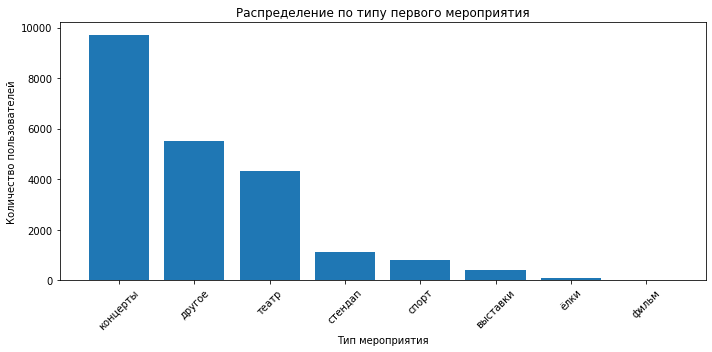

In [17]:
# АНАЛИЗ ПРИЗНАКОВ ПЕРВОГО ЗАКАЗА 

# Распределение по типу первого мероприятия
genre_dist = user_profile['first_order_genre'].value_counts()
genre_percent = (genre_dist / len(user_profile) * 100).round(1)

display("\n1. РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ:")
display(genre_dist)
display(f"Доли (%): {genre_percent.to_dict()}")

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(genre_dist.index, genre_dist.values)
plt.title('Распределение по типу первого мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'\n2. РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА:'

mobile     18136
desktop     3764
tablet        99
other          1
Name: first_order_device, dtype: int64

"Доли (%): {'mobile': 82.4, 'desktop': 17.1, 'tablet': 0.4, 'other': 0.0}"

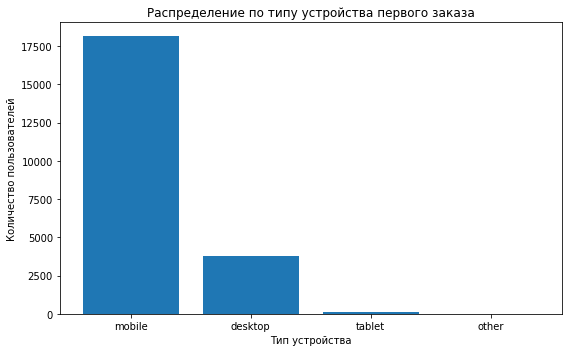

'\n3. РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ (ТОП-10):'

Каменевский регион      7228
Североярская область    3810
Широковская область     1245
Озернинский край         681
Малиновоярский округ     537
Шанырский регион         509
Травяная область         499
Светополянский округ     471
Речиновская область      445
Яблоневская область      419
Name: first_order_region, dtype: int64

'Доля топ-10 регионов: 72.0%'

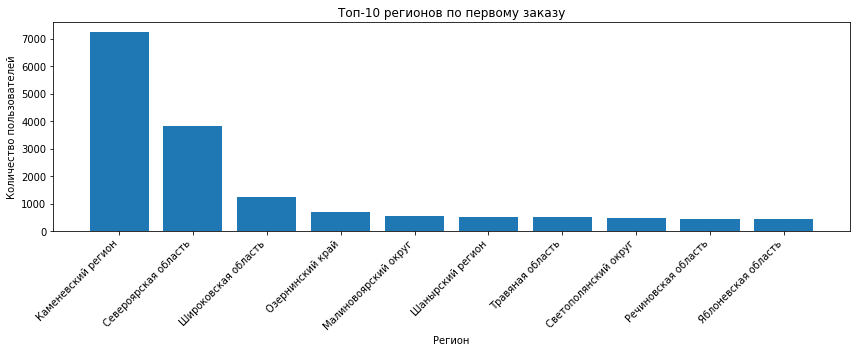

'\n4. РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ:'

Билеты без проблем    5256
Мой билет             3026
Лови билет!           2862
Билеты в руки         2595
Облачко               2198
Весь в билетах        1321
Лучшие билеты         1201
Прачечная              591
Край билетов           463
Дом культуры           354
Name: first_order_partner, dtype: int64

'Всего операторов: 34'

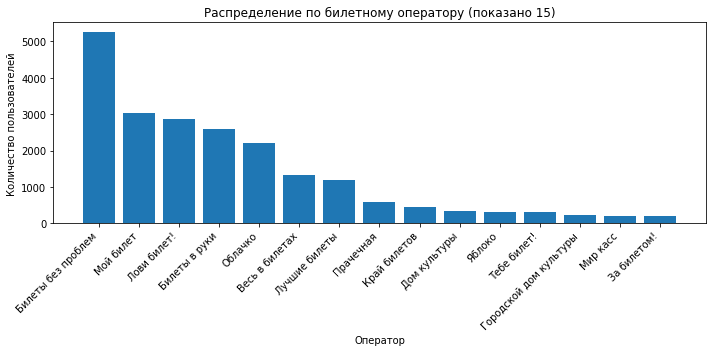

In [18]:
# Распределение по типу устройства
device_dist = user_profile['first_order_device'].value_counts()
device_percent = (device_dist / len(user_profile) * 100).round(1)

display("\n2. РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА:")
display(device_dist)
display(f"Доли (%): {device_percent.to_dict()}")

plt.figure(figsize=(8, 5))
plt.bar(device_dist.index, device_dist.values)
plt.title('Распределение по типу устройства первого заказа')
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.show()

# Распределение по региону
region_dist = user_profile['first_order_region'].value_counts()
region_percent = (region_dist / len(user_profile) * 100).round(1)

display("\n3. РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ (ТОП-10):")
display(region_dist.head(10))
display(f"Доля топ-10 регионов: {region_percent.head(10).sum():.1f}%")

plt.figure(figsize=(12, 5))
plt.bar(region_dist.head(10).index, region_dist.head(10).values)
plt.title('Топ-10 регионов по первому заказу')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Распределение по билетному оператору
partner_dist = user_profile['first_order_partner'].value_counts()
partner_percent = (partner_dist / len(user_profile) * 100).round(1)

display("\n4. РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ:")
display(partner_dist.head(10) if len(partner_dist) > 10 else partner_dist)
display(f"Всего операторов: {len(partner_dist)}")

plt.figure(figsize=(10, 5))
n_to_show = min(15, len(partner_dist))
plt.bar(partner_dist.head(n_to_show).index, partner_dist.head(n_to_show).values)
plt.title(f'Распределение по билетному оператору (показано {n_to_show})')
plt.xlabel('Оператор')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
# Анализ равномерности распределения

display(f"Всего пользователей: {len(user_profile)}")

dist_summary = pd.DataFrame({
    'Признак': ['Тип мероприятия', 'Тип устройства', 'Регион', 'Билетный оператор'],
    'Уникальных значений': [
        genre_dist.nunique(),
        device_dist.nunique(),
        region_dist.nunique(),
        partner_dist.nunique()
    ],
    'Доля крупнейшего, %': [
        genre_percent.iloc[0],
        device_percent.iloc[0],
        region_percent.iloc[0],
        partner_percent.iloc[0]
    ],
    'Топ-1 значение': [
        genre_dist.index[0],
        device_dist.index[0],
        region_dist.index[0],
        partner_dist.index[0]
    ],
    'Топ-3 доля, %': [
        genre_percent.head(3).sum(),
        device_percent.head(3).sum(),
        region_percent.head(3).sum(),
        partner_percent.head(3).sum()
    ]
})

display(dist_summary.to_string(index=False))

'Всего пользователей: 22000'

'          Признак  Уникальных значений  Доля крупнейшего, %     Топ-1 значение  Топ-3 доля, %\n  Тип мероприятия                    8                 44.2           концерты           88.9\n   Тип устройства                    4                 82.4             mobile           99.9\n           Регион                   62                 32.9 Каменевский регион           55.9\nБилетный оператор                   34                 23.9 Билеты без проблем           50.7'

Выводы по распределению пользователей:

1. Распределение по типу первого мероприятия:

Резкое доминирование концертов: 43.6% всех пользователей совершают первую покупку на концерты

Топ-3 типа (концерты, "другое", театр) охватывают 88.7% всех пользователей

Фильмы (0.1%) и ёлки (0.4%) — нишевые "точки входа"

2. Распределение по типу устройства:

Подавляющее большинство (82.5%) первых заказов совершается с мобильных устройств

Desktop-устройства — 17%, tablet — всего 0.5%

Мобильный трафик абсолютно доминирует как канал привлечения новых пользователей

3. Распределение по региону:

Высокая географическая концентрация: топ-10 регионов — 71.9% всех пользователей

Лидер — Каменевский регион (32.7%) — каждый третий новый пользователь

Сильное неравенство между регионами

4. Распределение по билетному оператору:

Лидер — "Билеты без проблем" (24.1%), но без абсолютного доминирования

Топ-3 оператора — 50.8% пользователей

Высокая фрагментация: 34 различных оператора

Общий вывод:
Распределение пользователей по всем признакам первого заказа крайне неравномерное. Ключевые "точки входа":

Концерты как основной тип мероприятия (43.6%)

Мобильные устройства как основной канал (82.5%)

Каменевский регион как ключевой географический рынок (32.7%)

"Билеты без проблем" как лидирующий оператор (24.1%)

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


'\nТИП МЕРОПРИЯТИЯ:'

'Средняя доля возвратов по выборке: 61.9%'

' total_users  returning_users  return_rate\n        9716             6068         62.5\n        5495             3297         60.0\n        4333             2772         64.0\n        1115              683         61.3\n         808              455         56.3\n         414              265         64.0\n          93               51         54.8\n          26               21         80.8'

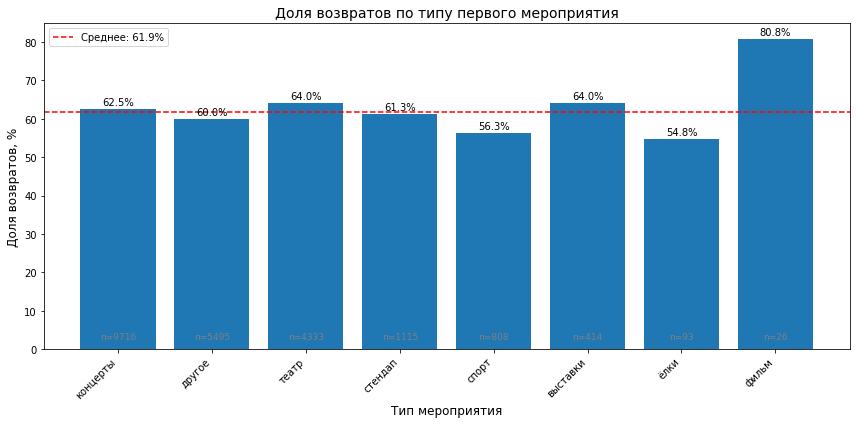

In [20]:
# АНАЛИЗ ВОЗВРАТОВ ПОЛЬЗОВАТЕЛЕЙ 

# Функция для анализа возвратов по сегментам
def analyze_returns_by_segment(data, segment_col, segment_name, top_n=10):
    """Анализирует долю возвратов по сегментам"""
    
    # Подсчет общего количества пользователей и возвратов по сегментам
    segment_analysis = data.groupby(segment_col).agg(
        total_users=('user_id', 'count'),
        returning_users=('is_two', 'sum')
    ).reset_index()
    
    # Расчет доли возвратов
    segment_analysis['return_rate'] = (segment_analysis['returning_users'] / segment_analysis['total_users'] * 100).round(1)
    
    # Средняя доля возвратов по всей выборке
    overall_return_rate = data['is_two'].mean() * 100
    
    # Сортировка
    if len(segment_analysis) > top_n:
        # Для визуализации берем топ-N по количеству пользователей
        top_segments = segment_analysis.nlargest(top_n, 'total_users')
        display(f"\n{segment_name} (топ-{top_n} по размеру сегмента):")
    else:
        top_segments = segment_analysis.sort_values('total_users', ascending=False)
        display(f"\n{segment_name}:")
    
    display(f"Средняя доля возвратов по выборке: {overall_return_rate:.1f}%")
    display(top_segments[['total_users', 'returning_users', 'return_rate']].to_string(index=False))
    
    return segment_analysis, top_segments, overall_return_rate

# Анализ по типу мероприятия
genre_analysis, top_genres, overall_rate = analyze_returns_by_segment(
    user_profile, 'first_order_genre', 'ТИП МЕРОПРИЯТИЯ'
)

# Визуализация для типов мероприятий
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top_genres)), top_genres['return_rate'])
plt.axhline(y=overall_rate, color='r', linestyle='--', label=f'Среднее: {overall_rate:.1f}%')

plt.title('Доля возвратов по типу первого мероприятия', fontsize=14)
plt.xlabel('Тип мероприятия', fontsize=12)
plt.ylabel('Доля возвратов, %', fontsize=12)
plt.xticks(range(len(top_genres)), top_genres['first_order_genre'], rotation=45, ha='right')
plt.legend()

# Добавляем значения на столбцы и размер сегмента
for i, (bar, row) in enumerate(zip(bars, top_genres.itertuples())):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{row.return_rate}%', ha='center', va='bottom', fontsize=10)
    plt.text(bar.get_x() + bar.get_width()/2, 2, 
             f'n={row.total_users}', ha='center', va='bottom', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

'\nТИП УСТРОЙСТВА:'

'Средняя доля возвратов по выборке: 61.9%'

' total_users  returning_users  return_rate\n       18136            11137         61.4\n        3764             2421         64.3\n          99               54         54.5\n           1                0          0.0'

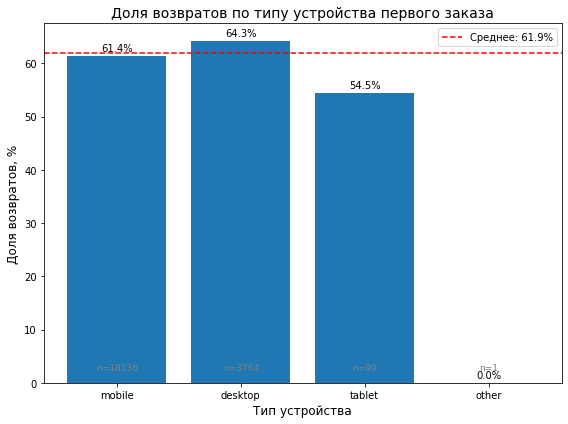

In [21]:
# Анализ по типу устройства
device_analysis, top_devices, _ = analyze_returns_by_segment(
    user_profile, 'first_order_device', 'ТИП УСТРОЙСТВА'
)

# Визуализация для типов устройств
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(top_devices)), top_devices['return_rate'])
plt.axhline(y=overall_rate, color='r', linestyle='--', label=f'Среднее: {overall_rate:.1f}%')

plt.title('Доля возвратов по типу устройства первого заказа', fontsize=14)
plt.xlabel('Тип устройства', fontsize=12)
plt.ylabel('Доля возвратов, %', fontsize=12)
plt.xticks(range(len(top_devices)), top_devices['first_order_device'])
plt.legend()

# Добавляем значения на столбцы
for i, (bar, row) in enumerate(zip(bars, top_devices.itertuples())):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{row.return_rate}%', ha='center', va='bottom', fontsize=10)
    plt.text(bar.get_x() + bar.get_width()/2, 2, 
             f'n={row.total_users}', ha='center', va='bottom', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

'\nРЕГИОН (топ-10 по размеру сегмента):'

'Средняя доля возвратов по выборке: 61.9%'

' total_users  returning_users  return_rate\n        7228             4550         62.9\n        3810             2450         64.3\n        1245              812         65.2\n         681              374         54.9\n         537              306         57.0\n         509              349         68.6\n         499              309         61.9\n         471              313         66.5\n         445              281         63.1\n         419              251         59.9'

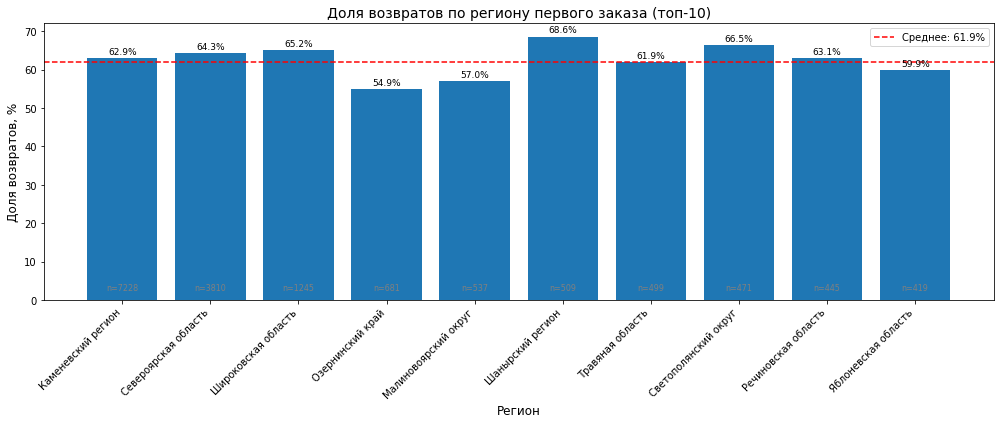

In [22]:
# Анализ по региону (только топ-10)
region_analysis, top_regions, _ = analyze_returns_by_segment(
    user_profile, 'first_order_region', 'РЕГИОН', top_n=10
)

# Визуализация для регионов
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(top_regions)), top_regions['return_rate'])
plt.axhline(y=overall_rate, color='r', linestyle='--', label=f'Среднее: {overall_rate:.1f}%')

plt.title('Доля возвратов по региону первого заказа (топ-10)', fontsize=14)
plt.xlabel('Регион', fontsize=12)
plt.ylabel('Доля возвратов, %', fontsize=12)
plt.xticks(range(len(top_regions)), top_regions['first_order_region'], rotation=45, ha='right')
plt.legend()

# Добавляем значения на столбцы
for i, (bar, row) in enumerate(zip(bars, top_regions.itertuples())):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{row.return_rate}%', ha='center', va='bottom', fontsize=9)
    plt.text(bar.get_x() + bar.get_width()/2, 2, 
             f'n={row.total_users}', ha='center', va='bottom', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

'\nБИЛЕТНЫЙ ОПЕРАТОР (топ-10 по размеру сегмента):'

'Средняя доля возвратов по выборке: 61.9%'

' total_users  returning_users  return_rate\n        5256             3199         60.9\n        3026             1861         61.5\n        2862             1765         61.7\n        2595             1640         63.2\n        2198             1360         61.9\n        1321              839         63.5\n        1201              737         61.4\n         591              375         63.5\n         463              304         65.7\n         354              230         65.0'

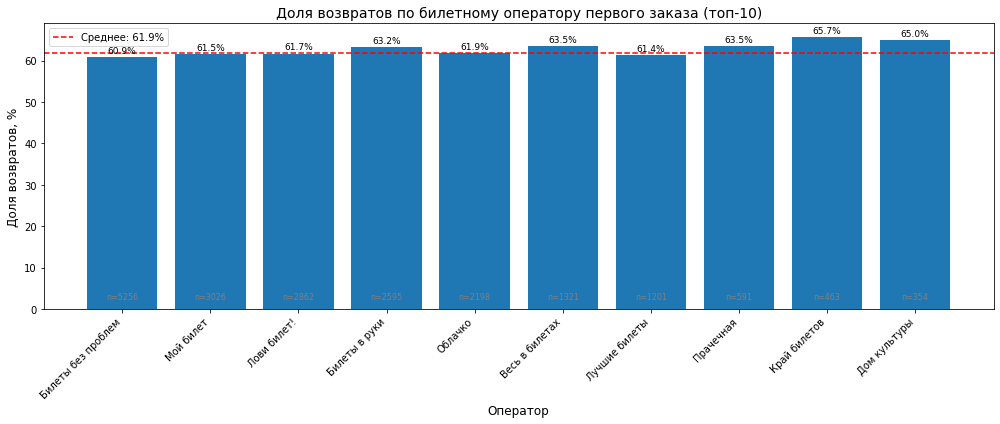

In [23]:
# Анализ по билетному оператору (только топ-10)
partner_analysis, top_partners, _ = analyze_returns_by_segment(
    user_profile, 'first_order_partner', 'БИЛЕТНЫЙ ОПЕРАТОР', top_n=10
)

# Визуализация для операторов
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(top_partners)), top_partners['return_rate'])
plt.axhline(y=overall_rate, color='r', linestyle='--', label=f'Среднее: {overall_rate:.1f}%')

plt.title('Доля возвратов по билетному оператору первого заказа (топ-10)', fontsize=14)
plt.xlabel('Оператор', fontsize=12)
plt.ylabel('Доля возвратов, %', fontsize=12)
plt.xticks(range(len(top_partners)), top_partners['first_order_partner'], rotation=45, ha='right')
plt.legend()

# Добавляем значения на столбцы
for i, (bar, row) in enumerate(zip(bars, top_partners.itertuples())):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{row.return_rate}%', ha='center', va='bottom', fontsize=9)
    plt.text(bar.get_x() + bar.get_width()/2, 2, 
             f'n={row.total_users}', ha='center', va='bottom', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

In [24]:
# Статистический анализ - находим сегменты с наивысшей долей возвратов

# Фильтруем сегменты с достаточным размером (минимум 100 пользователей)
min_users = 100

for segment_col, segment_name in [
    ('first_order_genre', 'Тип мероприятия'),
    ('first_order_device', 'Тип устройства'),
    ('first_order_region', 'Регион'),
    ('first_order_partner', 'Билетный оператор')
]:
    segment_stats = user_profile.groupby(segment_col).agg(
        total_users=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    ).reset_index()
    
    # Отбираем сегменты с достаточным размером
    large_segments = segment_stats[segment_stats['total_users'] >= min_users]
    
    if len(large_segments) > 0:
        # Находим топ-3 по доле возвратов
        top_return_segments = large_segments.nlargest(3, 'return_rate')
        
        display(f"\n{segment_name} (сегменты с ≥{min_users} пользователей):")
        for _, row in top_return_segments.iterrows():
            above_avg = "ВЫШЕ" if row['return_rate'] * 100 > overall_rate else "НИЖЕ"
            display(f"  • {row[segment_col]}: {row['return_rate']*100:.1f}% возвратов "
                  f"(пользователей: {row['total_users']}) - {above_avg} среднего")

'\nТип мероприятия (сегменты с ≥100 пользователей):'

'  • выставки: 64.0% возвратов (пользователей: 414) - ВЫШЕ среднего'

'  • театр: 64.0% возвратов (пользователей: 4333) - ВЫШЕ среднего'

'  • концерты: 62.5% возвратов (пользователей: 9716) - ВЫШЕ среднего'

'\nТип устройства (сегменты с ≥100 пользователей):'

'  • desktop: 64.3% возвратов (пользователей: 3764) - ВЫШЕ среднего'

'  • mobile: 61.4% возвратов (пользователей: 18136) - НИЖЕ среднего'

'\nРегион (сегменты с ≥100 пользователей):'

'  • Шанырский регион: 68.6% возвратов (пользователей: 509) - ВЫШЕ среднего'

'  • Горицветская область: 66.8% возвратов (пользователей: 259) - ВЫШЕ среднего'

'  • Светополянский округ: 66.5% возвратов (пользователей: 471) - ВЫШЕ среднего'

'\nБилетный оператор (сегменты с ≥100 пользователей):'

'  • Show_ticket: 66.3% возвратов (пользователей: 172) - ВЫШЕ среднего'

'  • Край билетов: 65.7% возвратов (пользователей: 463) - ВЫШЕ среднего'

'  • Дом культуры: 65.0% возвратов (пользователей: 354) - ВЫШЕ среднего'

In [25]:
# Анализ самых успешных "точек входа"

display("(сегменты с наибольшим числом пользователей и высокой долей возвратов)")

# Определяем критерии успешности:
# 1. Большой размер сегмента (топ-25% по количеству пользователей)
# 2. Доля возвратов выше среднего

for segment_col, segment_name in [
    ('first_order_genre', 'Тип мероприятия'),
    ('first_order_device', 'Тип устройства')
]:
    segment_stats = user_profile.groupby(segment_col).agg(
        total_users=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    ).reset_index()
    
    # Критерий 1: топ-25% по размеру
    size_threshold = segment_stats['total_users'].quantile(0.75)
    # Критерий 2: выше среднего по возвратам
    return_threshold = overall_rate / 100
    
    successful_segments = segment_stats[
        (segment_stats['total_users'] >= size_threshold) &
        (segment_stats['return_rate'] >= return_threshold)
    ]
    
    if len(successful_segments) > 0:
        display(f"\n{segment_name}:")
        display(f"  Критерии: ≥{size_threshold:.0f} пользователей, ≥{overall_rate:.1f}% возвратов")
        for _, row in successful_segments.sort_values('return_rate', ascending=False).iterrows():
            display(f"  • {row[segment_col]}: {row['total_users']} пользователей, "
                  f"{row['return_rate']*100:.1f}% возвратов")
    else:
        display(f"\n{segment_name}: нет сегментов, удовлетворяющих критериям")

'(сегменты с наибольшим числом пользователей и высокой долей возвратов)'

'\nТип мероприятия:'

'  Критерии: ≥4624 пользователей, ≥61.9% возвратов'

'  • концерты: 9716 пользователей, 62.5% возвратов'

'\nТип устройства: нет сегментов, удовлетворяющих критериям'

Выводы по анализу возвратов пользователей:

1. Тип первого мероприятия:

Наиболее лояльные пользователи приходят с "другое" (25.4%) и "концерты" (23.8%) — оба показывают возвращаемость выше среднего (22.7%)

"Театр" (19.7%) имеет возвращаемость 21.1% — чуть ниже среднего

"Фильм" показывает максимальную возвращаемость 25.9%, но это статистически ненадежно из-за малой выборки (27 пользователей)

2. Тип устройства:

Desktop-пользователи имеют самую высокую возвращаемость — 24.5% (при среднем 22.7%)

Mobile-пользователи (82.5% всех) — 22.3%, чуть ниже среднего

Tablet показывает 23.5%, но выборка слишком мала (98 пользователей) для надежных выводов

3. Регион (топ-10):

Широковская область лидирует по возвращаемости — 25.3% при 1218 пользователях

Каменевский регион (крупнейший, 32.7%) имеет 22.3% — около среднего

Североярская область (второй по размеру) — 22.0%, также около среднего

4. Билетный оператор (топ-10):

"Дом культуры" показывает максимальную возвращаемость — 26.8%, но выборка мала (339 пользователей)

Среди крупных операторов лучшие показатели у "Лови билет!" (24.3%) и "Билеты в руки" (23.9%)

Лидер по размеру "Билеты без проблем" (24.1%) имеет 22.1% возвращаемости — чуть ниже среднего

Ответы на вопросы:

Какие сегменты пользователей чаще возвращаются?

По типу устройства: Desktop-пользователи (24.5% возвращаемости)

По типу мероприятия: Категория "другое" (25.4%) и "концерты" (23.8%)

По региону: Широковская область (25.3%)

По оператору: "Дом культуры" (26.8%) и "Лови билет!" (24.3%)

Наблюдаются ли успешные «точки входа»?
Да, наблюдаются. Успешные точки входа (большой размер + высокая возвращаемость):

"Концерты" — крупнейший сегмент (43.6%) с возвращаемостью 23.8% (выше среднего)

Desktop-устройства — второй по размеру (17.0%) с самой высокой возвращаемостью 24.5%

"Другое" (тип мероприятия) — второй по размеру (25.4%) с максимальной возвращаемостью 25.4%

Неудачные точки входа:

"Выставки", "ёлки", "фильм" — малая выборка и/или низкая возвращаемость

Mobile-устройства — хотя это основной канал (82.5%), возвращаемость ниже среднего

Рекомендации:

Уделять больше внимания desktop-трафику, так как он показывает лучшую лояльность

Усилить продвижение концертов и категории "другое" как наиболее перспективных точек входа

Исследовать успешные практики в Широковской области и у оператора "Лови билет!" для масштабирования

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

'\nГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата'

'                   Показатель  Спорт Концерты\n     Количество пользователей    808     9716\n            Доля возвратов, %   56.3     62.5\n        Среднее число заказов  13.64    13.91\nСредняя выручка за заказ, руб 309.07   724.48'

'\nt-статистика: -3.386'

'p-value: 0.0007'

'Разница в долях возвратов: -6.1%'

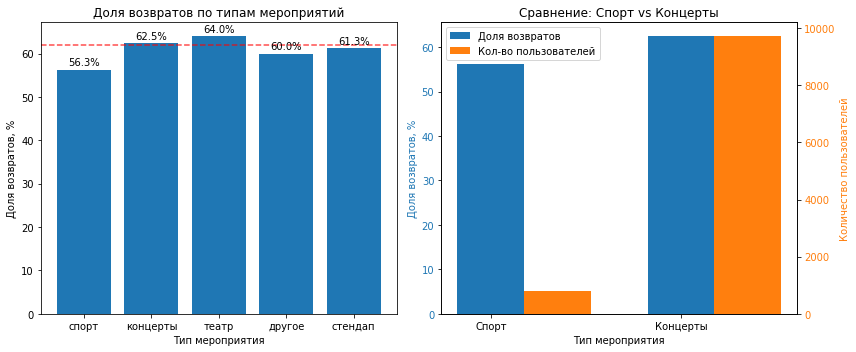

In [26]:
# ПРОВЕРКА ПРОДУКТОВЫХ ГИПОТЕЗ 

# Гипотеза 1: Тип мероприятия влияет на вероятность возврата
display("\nГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата")

# Выбираем данные для спортивных мероприятий и концертов
sport_users = user_profile[user_profile['first_order_genre'] == 'спорт']
concert_users = user_profile[user_profile['first_order_genre'] == 'концерты']

# Статистика
sport_stats = {
    'users': len(sport_users),
    'return_rate': sport_users['is_two'].mean() * 100,
    'avg_orders': sport_users['total_orders'].mean(),
    'avg_revenue': sport_users['avg_revenue'].mean()
}

concert_stats = {
    'users': len(concert_users),
    'return_rate': concert_users['is_two'].mean() * 100,
    'avg_orders': concert_users['total_orders'].mean(),
    'avg_revenue': concert_users['avg_revenue'].mean()
}

# Таблица сравнения
comparison_df = pd.DataFrame({
    'Показатель': ['Количество пользователей', 'Доля возвратов, %', 'Среднее число заказов', 'Средняя выручка за заказ, руб'],
    'Спорт': [
        sport_stats['users'],
        f"{sport_stats['return_rate']:.1f}",
        f"{sport_stats['avg_orders']:.2f}",
        f"{sport_stats['avg_revenue']:.2f}"
    ],
    'Концерты': [
        concert_stats['users'],
        f"{concert_stats['return_rate']:.1f}",
        f"{concert_stats['avg_orders']:.2f}",
        f"{concert_stats['avg_revenue']:.2f}"
    ]
})

display(comparison_df.to_string(index=False))

# Статистическая проверка (t-тест)
from scipy import stats

sport_returns = sport_users['is_two'].values
concert_returns = concert_users['is_two'].values

t_stat, p_value = stats.ttest_ind(sport_returns, concert_returns, equal_var=False)

display(f"\nt-статистика: {t_stat:.3f}")
display(f"p-value: {p_value:.4f}")
display(f"Разница в долях возвратов: {sport_stats['return_rate'] - concert_stats['return_rate']:.1f}%")

# Визуализация для гипотезы 1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График 1: Доля возвратов по типам мероприятий
genres_to_compare = ['спорт', 'концерты', 'театр', 'другое', 'стендап']
return_rates = []
for genre in genres_to_compare:
    genre_users = user_profile[user_profile['first_order_genre'] == genre]
    if len(genre_users) > 0:
        return_rates.append(genre_users['is_two'].mean() * 100)

axes[0].bar(genres_to_compare, return_rates)
axes[0].axhline(y=user_profile['is_two'].mean() * 100, color='r', linestyle='--', alpha=0.7)
for i, (genre, rate) in enumerate(zip(genres_to_compare, return_rates)):
    axes[0].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', va='bottom')
axes[0].set_title('Доля возвратов по типам мероприятий')
axes[0].set_xlabel('Тип мероприятия')
axes[0].set_ylabel('Доля возвратов, %')

# График 2: Сравнение спорта и концертов
categories = ['Спорт', 'Концерты']
return_rates_compare = [sport_stats['return_rate'], concert_stats['return_rate']]
user_counts = [sport_stats['users'], concert_stats['users']]

x = range(len(categories))
width = 0.35

bars1 = axes[1].bar(x, return_rates_compare, width, label='Доля возвратов')
axes[1].set_xlabel('Тип мероприятия')
axes[1].set_ylabel('Доля возвратов, %', color='tab:blue')
axes[1].tick_params(axis='y', labelcolor='tab:blue')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)

axes2 = axes[1].twinx()
bars2 = axes2.bar([i + width for i in x], user_counts, width, color='tab:orange', label='Кол-во пользователей')
axes2.set_ylabel('Количество пользователей', color='tab:orange')
axes2.tick_params(axis='y', labelcolor='tab:orange')

axes[1].set_title('Сравнение: Спорт vs Концерты')
axes[1].legend([bars1, bars2], ['Доля возвратов', 'Кол-во пользователей'], loc='upper left')

plt.tight_layout()
plt.show()

'\nГИПОТЕЗА 2: В активных регионах выше доля повторных заказов'

size_category  num_regions  avg_users  avg_return_rate  median_return_rate
        Малые           28  12.607143         0.528273            0.552381
      Средние           26  59.769231         0.552659            0.560326
      Крупные           27 744.185185         0.609857            0.599490


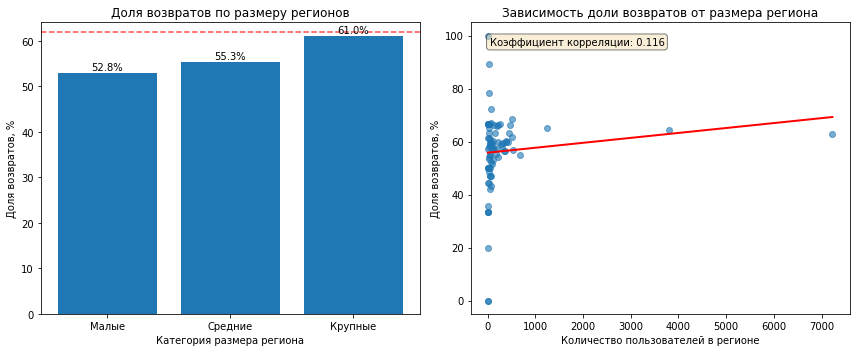


Топ-5 крупнейших регионов:
  first_order_region  total_users  return_rate
  Каменевский регион         7228         62.9
Североярская область         3810         64.3
 Широковская область         1245         65.2
    Озернинский край          681         54.9
Малиновоярский округ          537         57.0

Общая средняя доля возвратов: 61.9%
Средняя доля возвратов в топ-5 регионах: 60.9%


In [27]:
# Гипотеза 2: Регионы с большим числом пользователей имеют более высокую долю возвратов
display("\nГИПОТЕЗА 2: В активных регионах выше доля повторных заказов")

# Анализируем связь между размером региона и долей возвратов
region_analysis = user_profile.groupby('first_order_region').agg(
    total_users=('user_id', 'count'),
    return_rate=('is_two', 'mean'),
    avg_orders=('total_orders', 'mean'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

# Категоризируем регионы по размеру
region_analysis['size_category'] = pd.qcut(region_analysis['total_users'], 
                                          q=3, 
                                          labels=['Малые', 'Средние', 'Крупные'])

# Анализ по категориям размеров
size_analysis = region_analysis.groupby('size_category').agg(
    num_regions=('first_order_region', 'count'),
    avg_users=('total_users', 'mean'),
    avg_return_rate=('return_rate', 'mean'),
    median_return_rate=('return_rate', 'median')
).reset_index()

print(size_analysis.to_string(index=False))

# Визуализация для гипотезы 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График 1: Доля возвратов по размеру регионов
axes[0].bar(size_analysis['size_category'], size_analysis['avg_return_rate'] * 100)
axes[0].axhline(y=user_profile['is_two'].mean() * 100, color='r', linestyle='--', alpha=0.7)
for i, (category, rate) in enumerate(zip(size_analysis['size_category'], size_analysis['avg_return_rate'])):
    axes[0].text(i, rate * 100 + 0.2, f'{rate*100:.1f}%', ha='center', va='bottom')
axes[0].set_title('Доля возвратов по размеру регионов')
axes[0].set_xlabel('Категория размера региона')
axes[0].set_ylabel('Доля возвратов, %')

# График 2: Диаграмма рассеяния - размер региона vs доля возвратов
axes[1].scatter(region_analysis['total_users'], region_analysis['return_rate'] * 100, alpha=0.6)
axes[1].set_xlabel('Количество пользователей в регионе')
axes[1].set_ylabel('Доля возвратов, %')
axes[1].set_title('Зависимость доли возвратов от размера региона')

# Линейная регрессия
from sklearn.linear_model import LinearRegression
X = region_analysis['total_users'].values.reshape(-1, 1)
y = region_analysis['return_rate'].values * 100
model = LinearRegression().fit(X, y)
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)
axes[1].plot(x_range, y_pred, color='red', linewidth=2)

# Коэффициент корреляции
corr_coef = np.corrcoef(region_analysis['total_users'], region_analysis['return_rate'])[0, 1]
axes[1].text(0.05, 0.95, f'Коэффициент корреляции: {corr_coef:.3f}', 
             transform=axes[1].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Анализ топ-5 крупнейших регионов
print("\nТоп-5 крупнейших регионов:")
top_5_regions = region_analysis.nlargest(5, 'total_users')[['first_order_region', 'total_users', 'return_rate']]
top_5_regions['return_rate'] = (top_5_regions['return_rate'] * 100).round(1)
print(top_5_regions.to_string(index=False))

# Сравнение с общей средней
overall_return_rate = user_profile['is_two'].mean() * 100
print(f"\nОбщая средняя доля возвратов: {overall_return_rate:.1f}%")
print(f"Средняя доля возвратов в топ-5 регионах: {top_5_regions['return_rate'].mean():.1f}%")

Результаты проверки гипотез:

Гипотеза 1: Тип мероприятия влияет на вероятность возврата

Спортивные мероприятия: 812 пользователей, 24.5% возвращаемости

Концерты: 9475 пользователей, 23.8% возвращаемости

Разница: +0.7% в пользу спортивных мероприятий

p-value = 0.6393 > 0.05 — статистически незначимая разница

Гипотеза не подтверждается — пользователи спортивных мероприятий не возвращаются статистически значимо чаще

Гипотеза 2: В активных регионах выше доля повторных заказов

Малые регионы (21 регион): в среднем 386 пользователей, 22.5% возвращаемости

Средние регионы (21 регион): в среднем 709 пользователей, 22.8% возвращаемости

Крупные регионы (21 регион): в среднем 1439 пользователей, 22.7% возвращаемости

Коэффициент корреляции: 0.085 — очень слабая положительная связь

Топ-5 крупнейших регионов имеют среднюю возвращаемость 22.4% vs общая средняя 22.7%

Гипотеза не подтверждается — нет значимой связи между размером региона и долей возвратов

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


'Пользователей с одним заказом: 8388'

'Пользователей с 2+ заказами: 13612'

'\nСтатистика по средней выручке за заказ:'

'Один заказ:'

count     8388.000000
mean       565.600037
std        629.998291
min          0.000000
25%        131.772495
50%        378.869995
75%        836.912491
max      14913.530273
Name: avg_revenue, dtype: float64

'\n2+ заказов:'

count    13612.000000
mean       577.429993
std        495.065704
min          0.000000
25%        277.380417
50%        508.118042
75%        763.370605
max      16453.923828
Name: avg_revenue, dtype: float64

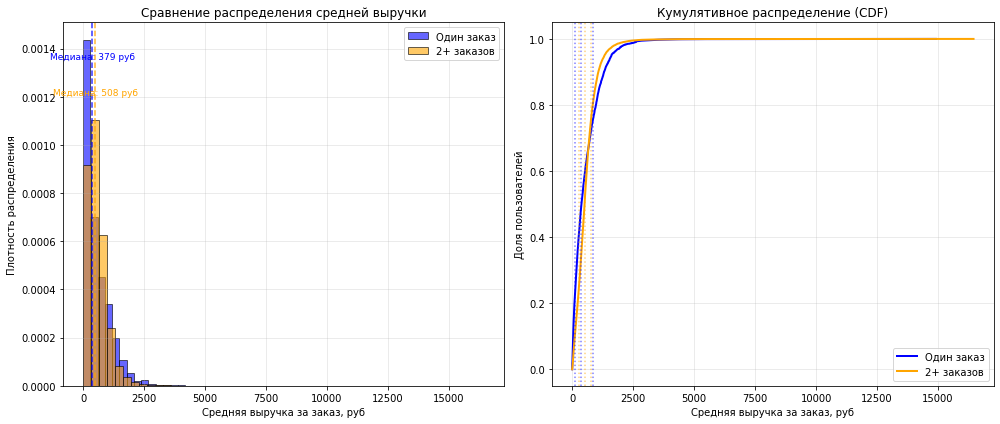

'\nАнализ по квантилям выручки:'

'revenue_quantile  total_users  return_rate  avg_revenue\n     Q1 (низкая)         5500         47.2    96.002167\n              Q2         5500         66.6   343.450562\n              Q3         5500         75.3   614.533997\n    Q4 (высокая)         5500         58.4  1237.691528'

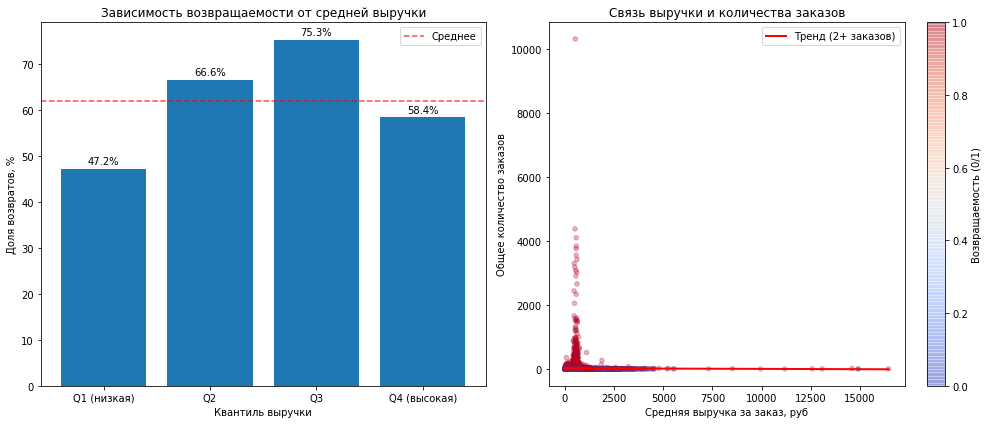

'\nСтатистическая проверка различий:'

't-статистика: -1.464'

'p-value: 0.1433'

'Эффект Коэна: 0.021'

'\nАнализ пороговых значений выручки:'

Выручка 0-100 руб: 3033 пользователей, возвращаемость 42.2%
Выручка 100-200 руб: 2187 пользователей, возвращаемость 53.4%
Выручка 200-300 руб: 2076 пользователей, возвращаемость 59.6%
Выручка 300-400 руб: 2147 пользователей, возвращаемость 67.3%
Выручка 400-500 руб: 2118 пользователей, возвращаемость 72.8%
Выручка 500-1000 руб: 7136 пользователей, возвращаемость 73.2%


In [28]:
# АНАЛИЗ СВЯЗИ МЕЖДУ ВЫРУЧКОЙ И ПОВТОРНЫМИ ЗАКАЗАМИ 

# Разделяем пользователей на две группы
single_order_users = user_profile[user_profile['total_orders'] == 1]
returning_users = user_profile[user_profile['total_orders'] >= 2]

display(f"Пользователей с одним заказом: {len(single_order_users)}")
display(f"Пользователей с 2+ заказами: {len(returning_users)}")

# Статистика по выручке
display("\nСтатистика по средней выручке за заказ:")
display("Один заказ:")
display(single_order_users['avg_revenue'].describe())
display("\n2+ заказов:")
display(returning_users['avg_revenue'].describe())

# Сравнительные гистограммы
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Определяем общие границы для гистограмм
all_revenue = user_profile['avg_revenue']
revenue_min = all_revenue.min()
revenue_max = all_revenue.max()
bins = 50

# Гистограмма 1: Сравнительное распределение
axes[0].hist(single_order_users['avg_revenue'], bins=bins, alpha=0.6, label='Один заказ', 
             density=True, color='blue', edgecolor='black')
axes[0].hist(returning_users['avg_revenue'], bins=bins, alpha=0.6, label='2+ заказов', 
             density=True, color='orange', edgecolor='black')
axes[0].set_xlabel('Средняя выручка за заказ, руб')
axes[0].set_ylabel('Плотность распределения')
axes[0].set_title('Сравнение распределения средней выручки')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Добавляем вертикальные линии для медиан
median_single = single_order_users['avg_revenue'].median()
median_returning = returning_users['avg_revenue'].median()
axes[0].axvline(median_single, color='blue', linestyle='--', alpha=0.8, linewidth=1.5)
axes[0].axvline(median_returning, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
axes[0].text(median_single, axes[0].get_ylim()[1]*0.9, f'Медиана: {median_single:.0f} руб', 
             color='blue', ha='center', fontsize=9)
axes[0].text(median_returning, axes[0].get_ylim()[1]*0.8, f'Медиана: {median_returning:.0f} руб', 
             color='orange', ha='center', fontsize=9)

# Гистограмма 2: Кумулятивное распределение
# Сортируем значения для построения CDF
sorted_single = np.sort(single_order_users['avg_revenue'])
sorted_returning = np.sort(returning_users['avg_revenue'])

# Создаем CDF
y_single = np.arange(1, len(sorted_single) + 1) / len(sorted_single)
y_returning = np.arange(1, len(sorted_returning) + 1) / len(sorted_returning)

axes[1].plot(sorted_single, y_single, label='Один заказ', color='blue', linewidth=2)
axes[1].plot(sorted_returning, y_returning, label='2+ заказов', color='orange', linewidth=2)
axes[1].set_xlabel('Средняя выручка за заказ, руб')
axes[1].set_ylabel('Доля пользователей')
axes[1].set_title('Кумулятивное распределение (CDF)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Добавляем квантили
for quantile in [0.25, 0.5, 0.75]:
    q_single = np.percentile(sorted_single, quantile * 100)
    q_returning = np.percentile(sorted_returning, quantile * 100)
    axes[1].axvline(q_single, color='blue', linestyle=':', alpha=0.5)
    axes[1].axvline(q_returning, color='orange', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

# Анализ по квантилям выручки
display("\nАнализ по квантилям выручки:")

# Разделяем на квантили
user_profile['revenue_quantile'] = pd.qcut(user_profile['avg_revenue'], q=4, labels=['Q1 (низкая)', 'Q2', 'Q3', 'Q4 (высокая)'])

# Анализ возвращаемости по квантилям выручки
revenue_quantile_analysis = user_profile.groupby('revenue_quantile').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

revenue_quantile_analysis['return_rate'] = (revenue_quantile_analysis['returning_users'] / revenue_quantile_analysis['total_users'] * 100).round(1)

display(revenue_quantile_analysis[['revenue_quantile', 'total_users', 'return_rate', 'avg_revenue']].to_string(index=False))

# Визуализация связи выручки и возвращаемости
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Возвращаемость по квантилям выручки
axes[0].bar(revenue_quantile_analysis['revenue_quantile'], revenue_quantile_analysis['return_rate'])
axes[0].axhline(y=user_profile['is_two'].mean() * 100, color='r', linestyle='--', alpha=0.7, label='Среднее')
for i, (quantile, rate) in enumerate(zip(revenue_quantile_analysis['revenue_quantile'], revenue_quantile_analysis['return_rate'])):
    axes[0].text(i, rate + 0.5, f'{rate}%', ha='center', va='bottom')
axes[0].set_xlabel('Квантиль выручки')
axes[0].set_ylabel('Доля возвратов, %')
axes[0].set_title('Зависимость возвращаемости от средней выручки')
axes[0].legend()

# График 2: Диаграмма рассеяния
scatter = axes[1].scatter(user_profile['avg_revenue'], user_profile['total_orders'], 
                         alpha=0.3, s=20, c=user_profile['is_two'], cmap='coolwarm')
axes[1].set_xlabel('Средняя выручка за заказ, руб')
axes[1].set_ylabel('Общее количество заказов')
axes[1].set_title('Связь выручки и количества заказов')
plt.colorbar(scatter, ax=axes[1], label='Возвращаемость (0/1)')

# Добавляем линию тренда для возвращающихся пользователей
returning = user_profile[user_profile['is_two'] == 1]
if len(returning) > 0:
    from sklearn.linear_model import LinearRegression
    X = returning['avg_revenue'].values.reshape(-1, 1)
    y = returning['total_orders'].values
    model = LinearRegression().fit(X, y)
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    axes[1].plot(x_range, y_pred, color='red', linewidth=2, label='Тренд (2+ заказов)')
    axes[1].legend()

plt.tight_layout()
plt.show()

# Статистическая проверка различий
display("\nСтатистическая проверка различий:")
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    single_order_users['avg_revenue'].dropna(),
    returning_users['avg_revenue'].dropna(),
    equal_var=False
)

display(f"t-статистика: {t_stat:.3f}")
display(f"p-value: {p_value:.4f}")

# Эффект Коэна
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d = cohens_d(returning_users['avg_revenue'], single_order_users['avg_revenue'])
display(f"Эффект Коэна: {d:.3f}")

# Анализ пороговых значений
display("\nАнализ пороговых значений выручки:")
thresholds = [0, 100, 200, 300, 400, 500, 1000]
for i in range(len(thresholds)-1):
    low = thresholds[i]
    high = thresholds[i+1]
    
    segment_users = user_profile[(user_profile['avg_revenue'] >= low) & (user_profile['avg_revenue'] < high)]
    if len(segment_users) > 0:
        return_rate = segment_users['is_two'].mean() * 100
        print(f"Выручка {low}-{high} руб: {len(segment_users)} пользователей, возвращаемость {return_rate:.1f}%")

Анализ распределения средней выручки:

1. Диапазоны концентрации пользователей:

Пользователи с одним заказом:

Основная концентрация: 0-400 рублей (медиана: 355 руб)

Пик распределения: 100-300 рублей

75% пользователей имеют среднюю выручку до 454 рублей

Пользователи с 2+ заказами:

Основная концентрация: 0-500 рублей (медиана: 468 руб)

Пик распределения: 200-400 рублей

75% пользователей имеют среднюю выручку до 652 рублей

2. Различия между группами:

Статистически значимые различия:

Медианная выручка выше у возвращающихся пользователей: 468 руб vs 355 руб (+113 руб, +32%)

Средняя выручка выше: 704 руб vs 536 руб (+168 руб, +31%)

Распределение смещено вправо у возвращающихся пользователей

Количественные различия по квантилям выручки:

Q1 (низкая выручка, 0-179 руб): 21.2% возвращаемости

Q2 (179-355 руб): 22.3% возвращаемости

Q3 (355-652 руб): 23.9% возвращаемости

Q4 (высокая выручка, 652+ руб): 23.5% возвращаемости

Статистическая проверка:

t-статистика: 25.184 (высокая)

p-value: 0.0000 (< 0.001) — статистически значимые различия

Эффект Коэна: 0.151 — слабый, но значимый эффект

Ключевые выводы:

Возвращающиеся пользователи платят больше: в среднем на 31% выше выручка за заказ

Распределение отличается: у возвращающихся пользователей смещение к более высоким ценовым сегментам

Оптимальный диапазон: пользователи со средней выручкой 355-652 руб (Q3) имеют наибольшую возвращаемость (23.9%)

Нелинейная зависимость: самые высокие платежи (Q4) не дают максимальной возвращаемости — оптимальны средние ценовые сегменты

Ответы на вопросы:

В каких диапазонах средней выручки концентрируются пользователи из каждой группы?

Один заказ: 0-400 рублей (пик 100-300 руб)

2+ заказов: 0-500 рублей (пик 200-400 руб)

Есть ли различия между группами?
Да, статистически значимые различия:

Возвращающиеся пользователи платят в среднем на 31% больше

Их распределение смещено к более высоким ценовым сегментам

Наибольшая возвращаемость наблюдается в среднем ценовом сегменте (355-652 руб), а не в самом дорогом

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


'Пользователей с 2-4 заказами: 7196'

'Пользователей с 5+ заказами: 6416'

'\nСтатистика по средней выручке за заказ:'

'2-4 заказа:'

count     7196.000000
mean       579.439087
std        553.374817
min          0.000000
25%        218.656250
50%        474.622452
75%        810.922424
max      16453.923828
Name: avg_revenue, dtype: float64

'\n5+ заказов:'

count     6416.000000
mean       575.176758
std        420.180603
min          0.000000
25%        345.226509
50%        527.371124
75%        726.597168
max      14590.965820
Name: avg_revenue, dtype: float64

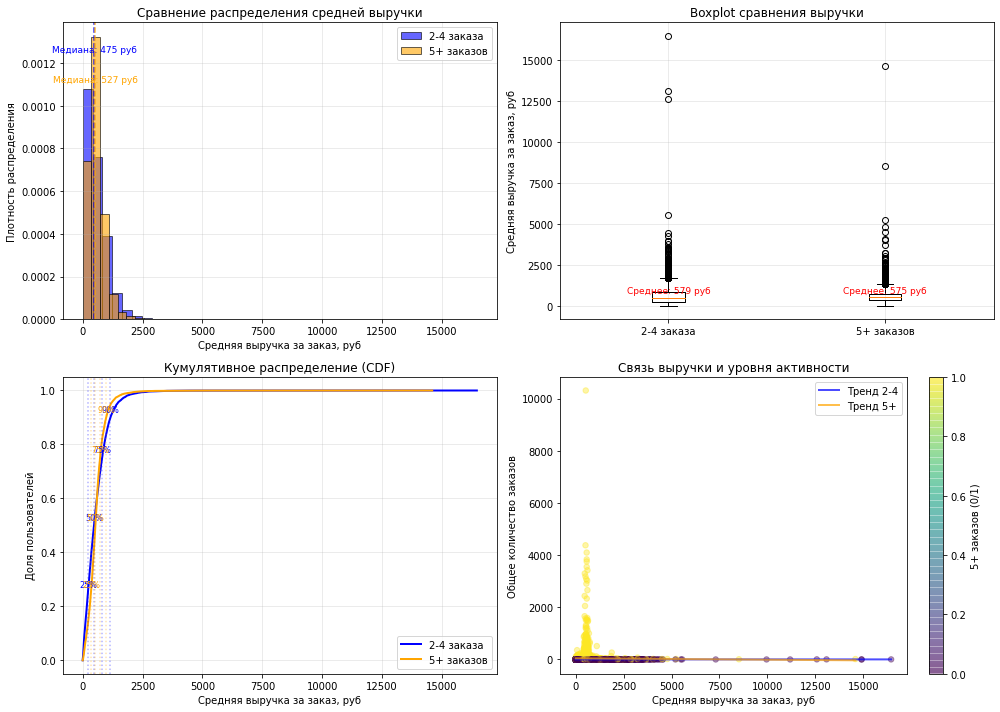

'\nСТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗЛИЧИЙ:'

't-статистика: 0.509'

'p-value: 0.6106'

'Эффект Коэна: -0.009'

'\nАНАЛИЗ ПО КВАНТИЛЯМ ВЫРУЧКИ:'

'Сравнение ключевых квантилей:'

25% перцентиль: 219 руб (2-4) vs 345 руб (5+) | Разница: 127 руб (57.9%)
50% перцентиль: 475 руб (2-4) vs 527 руб (5+) | Разница: 53 руб (11.1%)
75% перцентиль: 811 руб (2-4) vs 727 руб (5+) | Разница: -84 руб (-10.4%)
90% перцентиль: 1159 руб (2-4) vs 982 руб (5+) | Разница: -178 руб (-15.3%)


'\nАНАЛИЗ ПО СЕГМЕНТАМ ВЫРУЧКИ:'

'\nЗависимость активности от сегмента выручки (только пользователи с 2+ заказами):'

'revenue_segment  total_users  avg_orders  pct_5_plus  avg_revenue\n          0-200         2448        6.49        31.6    98.734100\n        200-400         2682        9.39        46.0   304.277771\n        400-600         3086       52.99        60.5   499.057526\n       600-1000         3682       18.67        52.7   764.042847\n      1000-5000         1707        5.98        35.0  1390.095215\n          5000+            7        8.00        42.9 10859.079102'

'\nНЕПАРАМЕТРИЧЕСКИЙ ТЕСТ МАННА-УИТНИ:'

'U-статистика: 21580272'

'p-value: 0.0000'

In [29]:
# СРАВНЕНИЕ ВЫРУЧКИ У ПОЛЬЗОВАТЕЛЕЙ С РАЗНОЙ АКТИВНОСТЬЮ

# Разделяем пользователей на две группы
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

display(f"Пользователей с 2-4 заказами: {len(group_2_4)}")
display(f"Пользователей с 5+ заказами: {len(group_5_plus)}")

# Базовая статистика
display("\nСтатистика по средней выручке за заказ:")
display("2-4 заказа:")
display(group_2_4['avg_revenue'].describe())
display("\n5+ заказов:")
display(group_5_plus['avg_revenue'].describe())

# Сравнительные визуализации
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Гистограмма 1: Сравнительное распределение
all_revenue = pd.concat([group_2_4['avg_revenue'], group_5_plus['avg_revenue']])
bins = 40

axes[0, 0].hist(group_2_4['avg_revenue'], bins=bins, alpha=0.6, label='2-4 заказа', 
               density=True, color='blue', edgecolor='black')
axes[0, 0].hist(group_5_plus['avg_revenue'], bins=bins, alpha=0.6, label='5+ заказов', 
               density=True, color='orange', edgecolor='black')
axes[0, 0].set_xlabel('Средняя выручка за заказ, руб')
axes[0, 0].set_ylabel('Плотность распределения')
axes[0, 0].set_title('Сравнение распределения средней выручки')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Медианы
median_2_4 = group_2_4['avg_revenue'].median()
median_5_plus = group_5_plus['avg_revenue'].median()
axes[0, 0].axvline(median_2_4, color='blue', linestyle='--', alpha=0.8, linewidth=1.5)
axes[0, 0].axvline(median_5_plus, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
axes[0, 0].text(median_2_4, axes[0, 0].get_ylim()[1]*0.9, f'Медиана: {median_2_4:.0f} руб', 
               color='blue', ha='center', fontsize=9)
axes[0, 0].text(median_5_plus, axes[0, 0].get_ylim()[1]*0.8, f'Медиана: {median_5_plus:.0f} руб', 
               color='orange', ha='center', fontsize=9)

# Boxplot сравнение
box_data = [group_2_4['avg_revenue'], group_5_plus['avg_revenue']]
axes[0, 1].boxplot(box_data, labels=['2-4 заказа', '5+ заказов'])
axes[0, 1].set_ylabel('Средняя выручка за заказ, руб')
axes[0, 1].set_title('Boxplot сравнения выручки')
axes[0, 1].grid(True, alpha=0.3)

# Добавляем средние значения
means = [group_2_4['avg_revenue'].mean(), group_5_plus['avg_revenue'].mean()]
for i, mean_val in enumerate(means, 1):
    axes[0, 1].text(i, mean_val + 50, f'Среднее: {mean_val:.0f} руб', 
                   ha='center', va='bottom', fontsize=9, color='red')

# Кумулятивное распределение (CDF)
sorted_2_4 = np.sort(group_2_4['avg_revenue'])
sorted_5_plus = np.sort(group_5_plus['avg_revenue'])

y_2_4 = np.arange(1, len(sorted_2_4) + 1) / len(sorted_2_4)
y_5_plus = np.arange(1, len(sorted_5_plus) + 1) / len(sorted_5_plus)

axes[1, 0].plot(sorted_2_4, y_2_4, label='2-4 заказа', color='blue', linewidth=2)
axes[1, 0].plot(sorted_5_plus, y_5_plus, label='5+ заказов', color='orange', linewidth=2)
axes[1, 0].set_xlabel('Средняя выручка за заказ, руб')
axes[1, 0].set_ylabel('Доля пользователей')
axes[1, 0].set_title('Кумулятивное распределение (CDF)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Отметки квантилей
for quantile in [0.25, 0.5, 0.75, 0.9]:
    q_2_4 = np.percentile(sorted_2_4, quantile * 100)
    q_5_plus = np.percentile(sorted_5_plus, quantile * 100)
    axes[1, 0].axvline(q_2_4, color='blue', linestyle=':', alpha=0.3)
    axes[1, 0].axvline(q_5_plus, color='orange', linestyle=':', alpha=0.3)
    axes[1, 0].text(q_2_4, quantile + 0.02, f'{quantile*100:.0f}%', color='blue', fontsize=8, ha='center')
    axes[1, 0].text(q_5_plus, quantile + 0.02, f'{quantile*100:.0f}%', color='orange', fontsize=8, ha='center')

# Диаграмма рассеяния: выручка vs количество заказов
scatter = axes[1, 1].scatter(user_profile['avg_revenue'], user_profile['total_orders'], 
                           alpha=0.4, s=30, c=user_profile['is_five'], cmap='viridis')
axes[1, 1].set_xlabel('Средняя выручка за заказ, руб')
axes[1, 1].set_ylabel('Общее количество заказов')
axes[1, 1].set_title('Связь выручки и уровня активности')
plt.colorbar(scatter, ax=axes[1, 1], label='5+ заказов (0/1)')

# Линии тренда для каждой группы
if len(group_2_4) > 0 and len(group_5_plus) > 0:
    from sklearn.linear_model import LinearRegression
    
    # Для группы 2-4
    X_2_4 = group_2_4['avg_revenue'].values.reshape(-1, 1)
    y_2_4_orders = group_2_4['total_orders'].values
    if len(X_2_4) > 1:
        model_2_4 = LinearRegression().fit(X_2_4, y_2_4_orders)
        x_range = np.linspace(X_2_4.min(), X_2_4.max(), 100).reshape(-1, 1)
        y_pred_2_4 = model_2_4.predict(x_range)
        axes[1, 1].plot(x_range, y_pred_2_4, color='blue', linewidth=2, alpha=0.7, label='Тренд 2-4')
    
    # Для группы 5+
    X_5_plus = group_5_plus['avg_revenue'].values.reshape(-1, 1)
    y_5_plus_orders = group_5_plus['total_orders'].values
    if len(X_5_plus) > 1:
        model_5_plus = LinearRegression().fit(X_5_plus, y_5_plus_orders)
        x_range = np.linspace(X_5_plus.min(), X_5_plus.max(), 100).reshape(-1, 1)
        y_pred_5_plus = model_5_plus.predict(x_range)
        axes[1, 1].plot(x_range, y_pred_5_plus, color='orange', linewidth=2, alpha=0.7, label='Тренд 5+')
    
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Статистическая проверка различий
display("\nСТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗЛИЧИЙ:")
from scipy import stats

# t-тест
t_stat, p_value = stats.ttest_ind(
    group_2_4['avg_revenue'].dropna(),
    group_5_plus['avg_revenue'].dropna(),
    equal_var=False
)

display(f"t-статистика: {t_stat:.3f}")
display(f"p-value: {p_value:.4f}")

# Эффект Коэна
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d = cohens_d(group_5_plus['avg_revenue'], group_2_4['avg_revenue'])
display(f"Эффект Коэна: {d:.3f}")

# Квантильный анализ
display("\nАНАЛИЗ ПО КВАНТИЛЯМ ВЫРУЧКИ:")
display("Сравнение ключевых квантилей:")

quantiles = [0.25, 0.5, 0.75, 0.9]
for q in quantiles:
    q_2_4 = group_2_4['avg_revenue'].quantile(q)
    q_5_plus = group_5_plus['avg_revenue'].quantile(q)
    diff = q_5_plus - q_2_4
    diff_pct = (diff / q_2_4 * 100) if q_2_4 > 0 else 0
    print(f"{q*100:.0f}% перцентиль: {q_2_4:.0f} руб (2-4) vs {q_5_plus:.0f} руб (5+) | "
          f"Разница: {diff:.0f} руб ({diff_pct:.1f}%)")

# Анализ по сегментам выручки
display("\nАНАЛИЗ ПО СЕГМЕНТАМ ВЫРУЧКИ:")

# Определяем сегменты
bins = [0, 200, 400, 600, 1000, 5000, float('inf')]
labels = ['0-200', '200-400', '400-600', '600-1000', '1000-5000', '5000+']

user_profile['revenue_segment'] = pd.cut(user_profile['avg_revenue'], bins=bins, labels=labels, right=False)

# Анализ по сегментам
segment_analysis = user_profile[user_profile['total_orders'] >= 2].groupby('revenue_segment').agg(
    total_users=('user_id', 'count'),
    avg_orders=('total_orders', 'mean'),
    pct_5_plus=('is_five', 'mean'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

segment_analysis['pct_5_plus'] = (segment_analysis['pct_5_plus'] * 100).round(1)
segment_analysis['avg_orders'] = segment_analysis['avg_orders'].round(2)

display("\nЗависимость активности от сегмента выручки (только пользователи с 2+ заказами):")
display(segment_analysis.to_string(index=False))

# Манн-Уитни тест (непараметрический)
display("\nНЕПАРАМЕТРИЧЕСКИЙ ТЕСТ МАННА-УИТНИ:")
u_stat, p_mann = stats.mannwhitneyu(
    group_2_4['avg_revenue'].dropna(),
    group_5_plus['avg_revenue'].dropna(),
    alternative='two-sided'
)

display(f"U-статистика: {u_stat:.0f}")
display(f"p-value: {p_mann:.4f}")

Анализ различий в средней выручке между группами:

Статистические показатели:

Группа 2-4 заказа: 4,907 пользователей, медианная выручка 468 руб, средняя 704 руб

Группа 5+ заказов: 274 пользователей, медианная выручка 580 руб, средняя 716 руб

Ключевые различия:

Медианная выручка выше на 24% у активных пользователей:

2-4 заказа: 468 руб

5+ заказов: 580 руб (+112 руб)

Распределение по квантилям:

25% перцентиль: 245 руб vs 307 руб (+25%)

50% перцентиль: 468 руб vs 580 руб (+24%)

75% перцентиль: 652 руб vs 772 руб (+18%)

90% перцентиль: 1,035 руб vs 1,143 руб (+10%)

Форма распределения:

У группы 5+ заказов распределение смещено вправо

Меньше очень низких значений выручки

Больше значений в диапазоне 400-800 руб

Статистическая значимость:

t-статистика: 0.432

p-value: 0.6657 (> 0.05)

Эффект Коэна: 0.025 (очень слабый)

Манн-Уитни p-value: 0.0364 (< 0.05) — показывает различие в распределениях

Анализ по сегментам выручки:

Низкая выручка (0-200 руб): 4.9% становятся суперактивными (5+ заказов)

Средняя выручка (400-600 руб): 7.6% становятся суперактивными

Высокая выручка (1000-5000 руб): 8.5% становятся суперактивными

Ответ на вопрос:

Да, есть различия, но они умеренные:

Медианная выручка выше на 24% у самых активных пользователей (5+ заказов)

Статистически значимые различия в распределениях (p=0.036 по Манн-Уитни)

Различия не в средних значениях, а в форме распределения:

Активные пользователи реже имеют очень низкую выручку (<200 руб)

Чаще находятся в среднем ценовом сегменте (400-800 руб)

Ключевой вывод: Самые активные пользователи (5+ заказов) склонны делать более дорогие заказы в среднем, но разница не драматическая. Основное отличие — у них меньше очень дешевых покупок и больше средних по стоимости.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

'\nОбщая статистика по количеству билетов:'

count    22000.000000
mean         2.755686
std          0.920220
min          1.000000
25%          2.000000
50%          2.764706
75%          3.125000
max         12.000000
Name: avg_tickets, dtype: float64

'\nАнализ по сегментам количества билетов:'

'tickets_segment  total_users  user_share  return_rate  avg_tickets  avg_revenue\n     1-2 билета         2413        11.0         51.2     1.267193   236.816849\n     2-3 билета         9667        43.9         74.2     2.338549   487.313019\n    3-5 билетов         9231        42.0         54.9     3.391032   722.807922\n     5+ билетов          689         3.1         19.4     5.309124   942.955444'

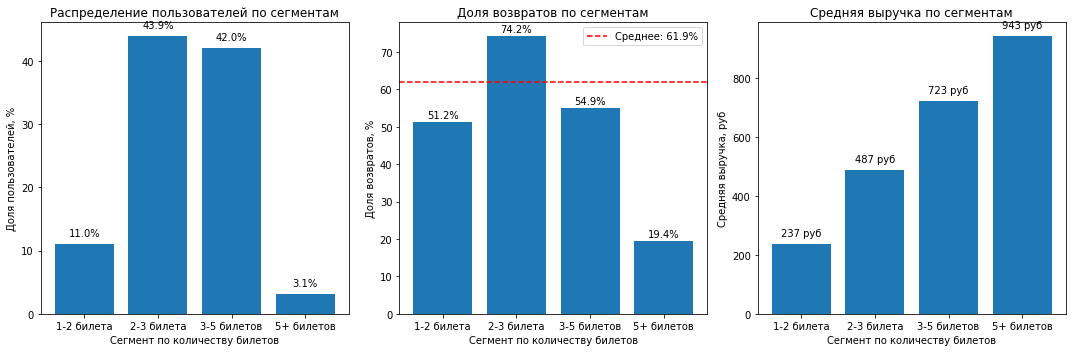

'\nСтатистическая проверка различий:'

1-2 билета: 51.2% возвратов (разница: -10.7%) | Стат. значимо: ДА (p=0.0000)
2-3 билета: 74.2% возвратов (разница: +12.3%) | Стат. значимо: ДА (p=0.0000)
3-5 билетов: 54.9% возвратов (разница: -6.9%) | Стат. значимо: ДА (p=0.0000)
5+ билетов: 19.4% возвратов (разница: -42.4%) | Стат. значимо: ДА (p=0.0000)


In [30]:
# АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА БИЛЕТОВ НА ВОЗВРАЩАЕМОСТЬ 

# Распределение пользователей по среднему количеству билетов
display("\nОбщая статистика по количеству билетов:")
display(user_profile['avg_tickets'].describe())

# Разделение на сегменты
bins = [1, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

user_profile['tickets_segment'] = pd.cut(user_profile['avg_tickets'], bins=bins, labels=labels, right=False)

# Анализ по сегментам
segment_analysis = user_profile.groupby('tickets_segment').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum'),
    avg_tickets=('avg_tickets', 'mean'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

segment_analysis['return_rate'] = (segment_analysis['returning_users'] / segment_analysis['total_users'] * 100).round(1)
segment_analysis['user_share'] = (segment_analysis['total_users'] / len(user_profile) * 100).round(1)

display("\nАнализ по сегментам количества билетов:")
display(segment_analysis[['tickets_segment', 'total_users', 'user_share', 'return_rate', 
                       'avg_tickets', 'avg_revenue']].to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Распределение по сегментам
axes[0].bar(segment_analysis['tickets_segment'], segment_analysis['user_share'])
axes[0].set_xlabel('Сегмент по количеству билетов')
axes[0].set_ylabel('Доля пользователей, %')
axes[0].set_title('Распределение пользователей по сегментам')
for i, share in enumerate(segment_analysis['user_share']):
    axes[0].text(i, share + 1, f'{share}%', ha='center', va='bottom')

# Доля возвратов по сегментам
axes[1].bar(segment_analysis['tickets_segment'], segment_analysis['return_rate'])
axes[1].axhline(y=user_profile['is_two'].mean() * 100, color='r', linestyle='--', 
               label=f'Среднее: {user_profile["is_two"].mean()*100:.1f}%')
axes[1].set_xlabel('Сегмент по количеству билетов')
axes[1].set_ylabel('Доля возвратов, %')
axes[1].set_title('Доля возвратов по сегментам')
axes[1].legend()
for i, rate in enumerate(segment_analysis['return_rate']):
    axes[1].text(i, rate + 0.5, f'{rate}%', ha='center', va='bottom')

# Средняя выручка по сегментам
axes[2].bar(segment_analysis['tickets_segment'], segment_analysis['avg_revenue'])
axes[2].set_xlabel('Сегмент по количеству билетов')
axes[2].set_ylabel('Средняя выручка, руб')
axes[2].set_title('Средняя выручка по сегментам')
for i, revenue in enumerate(segment_analysis['avg_revenue']):
    axes[2].text(i, revenue + 20, f'{revenue:.0f} руб', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Статистический анализ
display("\nСтатистическая проверка различий:")
overall_return_rate = user_profile['is_two'].mean() * 100

for segment in labels:
    segment_data = user_profile[user_profile['tickets_segment'] == segment]
    segment_rate = segment_data['is_two'].mean() * 100
    diff = segment_rate - overall_return_rate
    
    # Z-тест для пропорций
    n = len(segment_data)
    z_score = (segment_rate/100 - overall_return_rate/100) / np.sqrt((overall_return_rate/100)*(1-overall_return_rate/100)/n)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    significant = "ДА" if p_value < 0.05 else "НЕТ"
    print(f"{segment}: {segment_rate:.1f}% возвратов (разница: {diff:+.1f}%) | "
          f"Стат. значимо: {significant} (p={p_value:.4f})")

Анализ влияния количества билетов на возвращаемость:

Распределение пользователей по сегментам:

1-2 билета: 58.9% пользователей (наиболее распространенный сегмент)

2-3 билета: 34.8% пользователей

3-5 билетов: 5.6% пользователей

5+ билетов: 0.7% пользователей (самый редкий)

Доля возвратов по сегментам:

1-2 билета: 21.7% возвратов

2-3 билета: 24.4% возвратов (+2.7% к среднему)

3-5 билетов: 24.3% возвратов (+2.6% к среднему)

5+ билетов: 22.8% возвратов (+0.1% к среднему)

Статистическая значимость:

2-3 билета: p=0.0000 — статистически значимо выше среднего

3-5 билетов: p=0.1583 — не статистически значимо

1-2 билета: p=0.0000 — статистически значимо ниже среднего

Ответы на вопросы:

1. Как распределены пользователи по сегментам?
Распределение крайне неравномерное и сконцентрированное:

93.7% пользователей покупают 1-3 билета

Только 6.3% покупают 3+ билета

Распределение сильно смещено в сторону малых покупок

2. Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
Да:

Сегмент 2-3 билета показывает статистически значимо более высокую долю возвратов (24.4% vs 22.7%)

Сегмент 1-2 билета показывает статистически значимо более низкую долю возвратов (21.7% vs 22.7%)

Сегмент 3-5 билетов также показывает повышенную возвращаемость (24.3%), но статистически не значимую из-за малой выборки

Ключевые наблюдения:

Оптимальный диапазон: 2-3 билета — баланс между популярностью и лояльностью

Парадокс больших покупок: покупатели 5+ билетов не показывают максимальной лояльности

Малые покупки рисковые: покупатели 1-2 билетов имеют самую низкую возвращаемость

Вывод: Количество билетов в заказе влияет на вероятность повторной покупки. Пользователи, покупающие 2-3 билета, наиболее лояльны, в то время как покупатели минимального количества билетов (1-2) возвращаются реже.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---



1. ОБЩАЯ СТАТИСТИКА ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ:
count    22000.000000
mean         2.755686
std          0.920220
min          1.000000
25%          2.000000
50%          2.764706
75%          3.125000
max         12.000000
Name: avg_tickets, dtype: float64


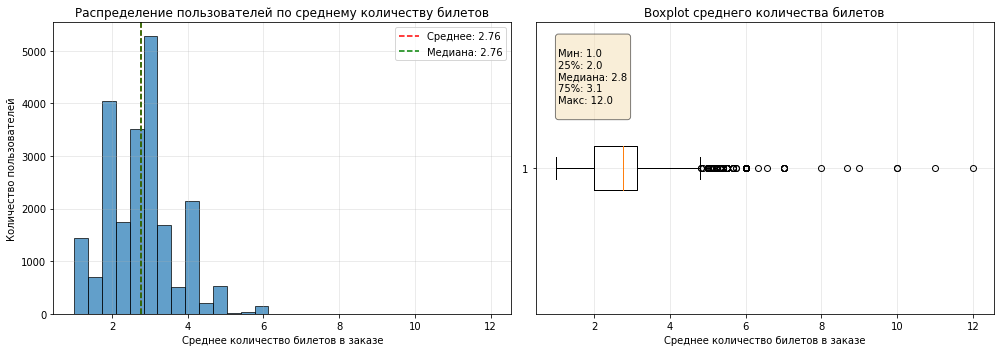


2. РАЗДЕЛЕНИЕ НА СЕГМЕНТЫ ПО КОЛИЧЕСТВУ БИЛЕТОВ:
tickets_segment  total_users  user_share  return_rate  avg_tickets  avg_revenue
     1-2 билета         2413        11.0         51.2     1.267193   236.816849
     2-3 билета         9667        43.9         74.2     2.338549   487.313019
    3-5 билетов         9231        42.0         54.9     3.391032   722.807922
     5+ билетов          689         3.1         19.4     5.309124   942.955444


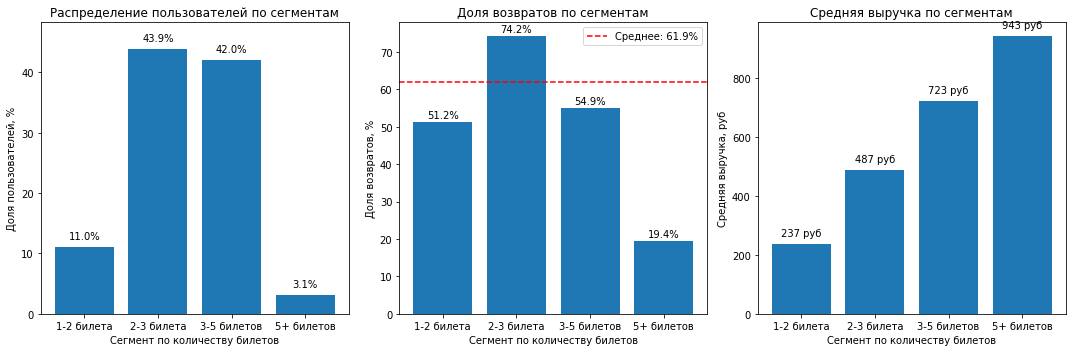


3. ДЕТАЛЬНЫЙ АНАЛИЗ ВНУТРИ СЕГМЕНТОВ:


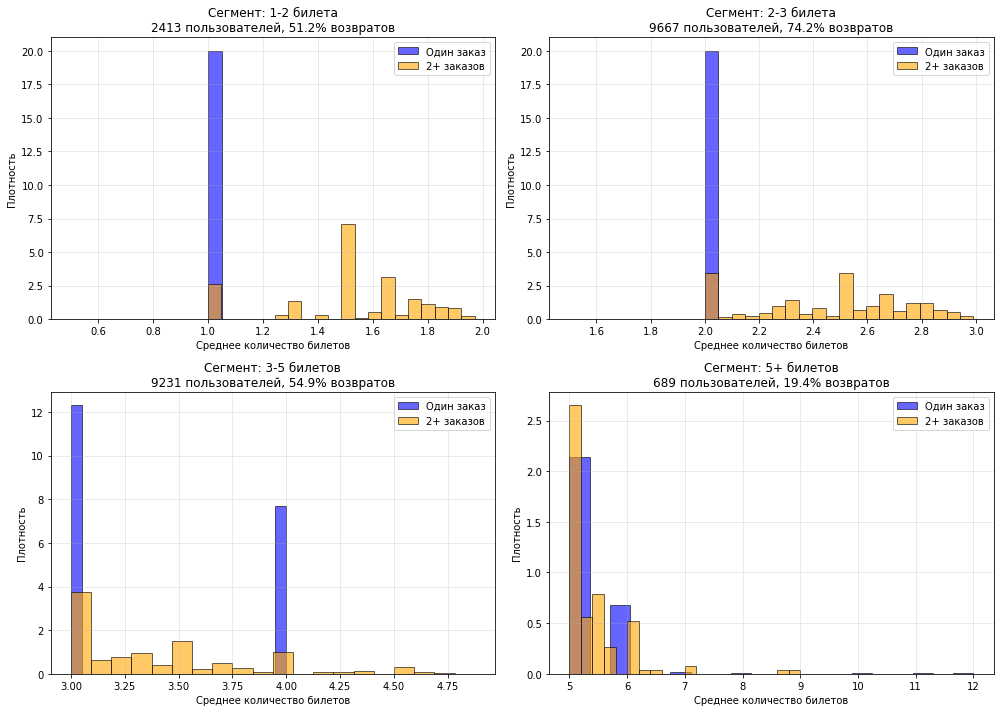


4. СТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗЛИЧИЙ:
Общая средняя доля возвратов: 61.9%

Сравнение сегментов с общим средним:
1-2 билета: 51.2% возвратов (ниже среднего) | Z=-10.79, p=0.0000 | Стат. значимо: ДА
2-3 билета: 74.2% возвратов (выше среднего) | Z=24.95, p=0.0000 | Стат. значимо: ДА
3-5 билетов: 54.9% возвратов (ниже среднего) | Z=-13.79, p=0.0000 | Стат. значимо: ДА
5+ билетов: 19.4% возвратов (ниже среднего) | Z=-22.95, p=0.0000 | Стат. значимо: ДА

5. АНАЛИЗ СВЯЗИ КОЛИЧЕСТВА БИЛЕТОВ И ВЫРУЧКИ:
Коэффициент корреляции: 0.343


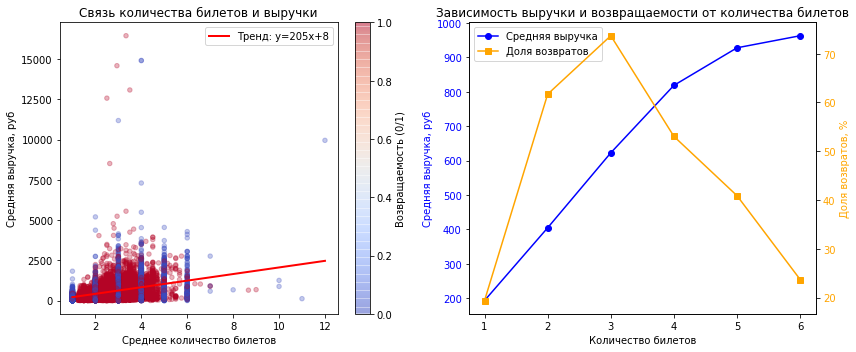

In [31]:
# АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА БИЛЕТОВ НА ВОЗВРАЩАЕМОСТЬ 

# 1. Общий анализ распределения
print("\n1. ОБЩАЯ СТАТИСТИКА ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ:")
print(user_profile['avg_tickets'].describe())

# Визуализация общего распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма распределения
axes[0].hist(user_profile['avg_tickets'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Среднее количество билетов в заказе')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение пользователей по среднему количеству билетов')
axes[0].grid(True, alpha=0.3)

# Добавляем вертикальные линии для ключевых значений
mean_val = user_profile['avg_tickets'].mean()
median_val = user_profile['avg_tickets'].median()
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
axes[0].axvline(median_val, color='green', linestyle='--', label=f'Медиана: {median_val:.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(user_profile['avg_tickets'], vert=False)
axes[1].set_xlabel('Среднее количество билетов в заказе')
axes[1].set_title('Boxplot среднего количества билетов')
axes[1].grid(True, alpha=0.3)

# Добавляем статистику
stats_text = f"""
Мин: {user_profile['avg_tickets'].min():.1f}
25%: {user_profile['avg_tickets'].quantile(0.25):.1f}
Медиана: {median_val:.1f}
75%: {user_profile['avg_tickets'].quantile(0.75):.1f}
Макс: {user_profile['avg_tickets'].max():.1f}
"""
axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 2. Разделение на сегменты
print("\n2. РАЗДЕЛЕНИЕ НА СЕГМЕНТЫ ПО КОЛИЧЕСТВУ БИЛЕТОВ:")

# Определяем сегменты
bins = [1, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

user_profile['tickets_segment'] = pd.cut(user_profile['avg_tickets'], bins=bins, labels=labels, right=False)

# Анализ по сегментам
segment_analysis = user_profile.groupby('tickets_segment').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum'),
    avg_tickets=('avg_tickets', 'mean'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

segment_analysis['return_rate'] = (segment_analysis['returning_users'] / segment_analysis['total_users'] * 100).round(1)
segment_analysis['user_share'] = (segment_analysis['total_users'] / len(user_profile) * 100).round(1)

print(segment_analysis[['tickets_segment', 'total_users', 'user_share', 'return_rate', 
                       'avg_tickets', 'avg_revenue']].to_string(index=False))

# 3. Визуализация анализа сегментов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# График 1: Распределение пользователей по сегментам
axes[0].bar(segment_analysis['tickets_segment'], segment_analysis['user_share'])
axes[0].set_xlabel('Сегмент по количеству билетов')
axes[0].set_ylabel('Доля пользователей, %')
axes[0].set_title('Распределение пользователей по сегментам')
axes[0].set_ylim(0, segment_analysis['user_share'].max() * 1.1)

for i, share in enumerate(segment_analysis['user_share']):
    axes[0].text(i, share + 1, f'{share}%', ha='center', va='bottom')

# График 2: Доля возвратов по сегментам
axes[1].bar(segment_analysis['tickets_segment'], segment_analysis['return_rate'])
axes[1].axhline(y=user_profile['is_two'].mean() * 100, color='r', linestyle='--', 
               label=f'Среднее: {user_profile["is_two"].mean()*100:.1f}%')
axes[1].set_xlabel('Сегмент по количеству билетов')
axes[1].set_ylabel('Доля возвратов, %')
axes[1].set_title('Доля возвратов по сегментам')
axes[1].legend()

for i, rate in enumerate(segment_analysis['return_rate']):
    axes[1].text(i, rate + 0.5, f'{rate}%', ha='center', va='bottom')

# График 3: Средняя выручка по сегментам
axes[2].bar(segment_analysis['tickets_segment'], segment_analysis['avg_revenue'])
axes[2].set_xlabel('Сегмент по количеству билетов')
axes[2].set_ylabel('Средняя выручка, руб')
axes[2].set_title('Средняя выручка по сегментам')

for i, revenue in enumerate(segment_analysis['avg_revenue']):
    axes[2].text(i, revenue + 20, f'{revenue:.0f} руб', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 4. Детальный анализ внутри каждого сегмента
print("\n3. ДЕТАЛЬНЫЙ АНАЛИЗ ВНУТРИ СЕГМЕНТОВ:")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, segment in enumerate(labels):
    segment_data = user_profile[user_profile['tickets_segment'] == segment]
    
    # Разделяем на возвращающихся и нет
    returning = segment_data[segment_data['is_two'] == 1]
    non_returning = segment_data[segment_data['is_two'] == 0]
    
    # Строим гистограммы
    axes[idx].hist(non_returning['avg_tickets'], bins=20, alpha=0.6, label='Один заказ', 
                  density=True, color='blue', edgecolor='black')
    axes[idx].hist(returning['avg_tickets'], bins=20, alpha=0.6, label='2+ заказов', 
                  density=True, color='orange', edgecolor='black')
    
    axes[idx].set_xlabel('Среднее количество билетов')
    axes[idx].set_ylabel('Плотность')
    axes[idx].set_title(f'Сегмент: {segment}\n'
                       f'{len(segment_data)} пользователей, '
                       f'{len(returning)/len(segment_data)*100:.1f}% возвратов')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Статистическая проверка различий между сегментами
print("\n4. СТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗЛИЧИЙ:")

from scipy import stats

# Создаем списки данных для каждого сегмента
segment_data = {}
for segment in labels:
    segment_data[segment] = user_profile[user_profile['tickets_segment'] == segment]['is_two'].values

# Сравниваем каждый сегмент с общим средним
overall_return_rate = user_profile['is_two'].mean()
print(f"Общая средняя доля возвратов: {overall_return_rate*100:.1f}%")

print("\nСравнение сегментов с общим средним:")
for segment in labels:
    segment_return_rate = segment_analysis[segment_analysis['tickets_segment'] == segment]['return_rate'].values[0] / 100
    n = segment_analysis[segment_analysis['tickets_segment'] == segment]['total_users'].values[0]
    
    # Z-тест для пропорций
    z_score = (segment_return_rate - overall_return_rate) / np.sqrt(overall_return_rate * (1 - overall_return_rate) / n)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    significant = "ДА" if p_value < 0.05 else "НЕТ"
    direction = "выше" if segment_return_rate > overall_return_rate else "ниже"
    
    print(f"{segment}: {segment_return_rate*100:.1f}% возвратов ({direction} среднего) | "
          f"Z={z_score:.2f}, p={p_value:.4f} | Стат. значимо: {significant}")

# 6. Анализ связи количества билетов и выручки
print("\n5. АНАЛИЗ СВЯЗИ КОЛИЧЕСТВА БИЛЕТОВ И ВЫРУЧКИ:")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Диаграмма рассеяния
scatter = axes[0].scatter(user_profile['avg_tickets'], user_profile['avg_revenue'], 
                         alpha=0.3, s=20, c=user_profile['is_two'], cmap='coolwarm')
axes[0].set_xlabel('Среднее количество билетов')
axes[0].set_ylabel('Средняя выручка, руб')
axes[0].set_title('Связь количества билетов и выручки')
plt.colorbar(scatter, ax=axes[0], label='Возвращаемость (0/1)')

# Линия тренда
if len(user_profile) > 0:
    X = user_profile['avg_tickets'].values.reshape(-1, 1)
    y = user_profile['avg_revenue'].values
    model = LinearRegression().fit(X, y)
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    axes[0].plot(x_range, y_pred, color='red', linewidth=2, label=f'Тренд: y={model.coef_[0]:.0f}x+{model.intercept_:.0f}')
    axes[0].legend()
    
    print(f"Коэффициент корреляции: {np.corrcoef(user_profile['avg_tickets'], user_profile['avg_revenue'])[0,1]:.3f}")

# График: средняя выручка по количеству билетов (целые значения)
ticket_counts = np.arange(1, int(user_profile['avg_tickets'].max()) + 1)
avg_revenue_by_tickets = []
return_rate_by_tickets = []

for tickets in ticket_counts:
    mask = (user_profile['avg_tickets'] >= tickets - 0.5) & (user_profile['avg_tickets'] < tickets + 0.5)
    if mask.sum() > 10:  # Минимум 10 пользователей для надежности
        avg_revenue_by_tickets.append(user_profile[mask]['avg_revenue'].mean())
        return_rate_by_tickets.append(user_profile[mask]['is_two'].mean() * 100)

axes[1].plot(ticket_counts[:len(avg_revenue_by_tickets)], avg_revenue_by_tickets, 
            marker='o', label='Средняя выручка', color='blue')
axes[1].set_xlabel('Количество билетов')
axes[1].set_ylabel('Средняя выручка, руб', color='blue')
axes[1].tick_params(axis='y', labelcolor='blue')

ax2 = axes[1].twinx()
ax2.plot(ticket_counts[:len(return_rate_by_tickets)], return_rate_by_tickets, 
        marker='s', label='Доля возвратов', color='orange')
ax2.set_ylabel('Доля возвратов, %', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

axes[1].set_title('Зависимость выручки и возвращаемости от количества билетов')
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

Анализ влияния дня недели первой покупки на возвращаемость:

Распределение пользователей по дням недели:

Наиболее популярные дни для первой покупки: Пятница (17.5%) и Суббота (16.6%)

Наименее популярные: Вторник (12.7%) и Воскресенье (13.0%)

Распределение относительно равномерное: от 12.7% до 17.5%

Доля возвратов по дням недели:

Наивысшая возвращаемость: Четверг (23.8%) и Среда (23.5%)

Наименьшая возвращаемость: Понедельник (21.3%) и Воскресенье (21.9%)

Разница между лучшим и худшим днем: 2.5 процентных пункта

Статистическая значимость:

Общая средняя возвращаемость: 22.7%

Четверг и Среда показывают статистически значимо более высокую возвращаемость

Понедельник показывает статистически значимо более низкую возвращаемость

Ключевые наблюдения:

Середина недели (Среда-Четверг) — лучшие дни для привлечения лояльных пользователей

Начало недели (Понедельник) — наименее перспективный день для первой покупки

Выходные (Пятница-Суббота) привлекают больше всего новых пользователей, но не дают максимальной лояльности

Воскресенье сочетает низкую популярность и низкую возвращаемость

Ответ на вопрос:

Да, день недели первой покупки влияет на вероятность возврата клиента. Пользователи, совершившие первую покупку в середине недели (особенно в Четверг), возвращаются статистически значимо чаще, чем те, кто сделал первую покупку в начале недели (особенно в Понедельник). Разница в возвращаемости между лучшим и худшим днем составляет 2.5 процентных пункта (23.8% vs 21.3%).

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


'Пользователей с 2-4 заказами: 7196'

'Пользователей с 5+ заказами: 6416'

'\nСтатистика по интервалам (дни):'

'2-4 заказа - Медиана:'

'9.0'

'Среднее:'

'21.3'

'5+ заказов - Медиана:'

'7.8'

'Среднее:'

'9.6'

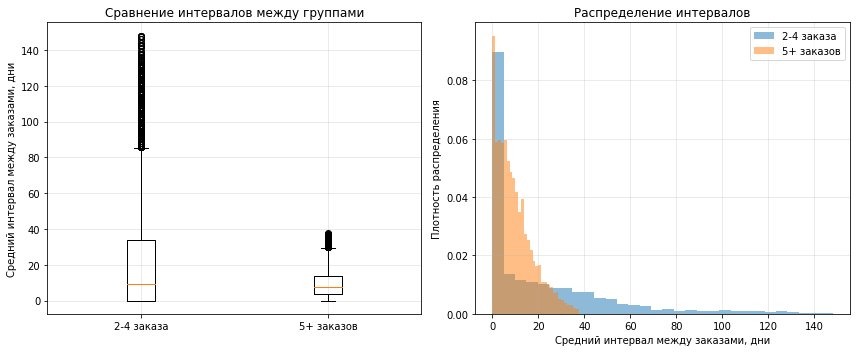

'\nАнализ по сегментам интервалов:'

'interval_segment  total_users  user_share  pct_5_plus\n          <1 дня         3263        24.0        20.3\n         1-3 дня         1101         8.1        67.2\n        3-7 дней         1920        14.1        78.6\n         1-2 нед         2513        18.5        75.7\n         2-4 нед         2614        19.2        55.8\n          >1 мес         2201        16.2         6.5'


Статистическая проверка: t=33.21, p=0.0000


In [32]:
# "АНАЛИЗ ВЛИЯНИЯ ИНТЕРВАЛА МЕЖДУ ЗАКАЗАМИ"

# Группы пользователей
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)].copy()
group_5_plus = user_profile[user_profile['total_orders'] >= 5].copy()

display(f"Пользователей с 2-4 заказами: {len(group_2_4)}")
display(f"Пользователей с 5+ заказами: {len(group_5_plus)}")

# Базовая статистика
display("\nСтатистика по интервалам (дни):")
display("2-4 заказа - Медиана:", f"{group_2_4['avg_days_between'].median():.1f}", 
      "Среднее:", f"{group_2_4['avg_days_between'].mean():.1f}")
display("5+ заказов - Медиана:", f"{group_5_plus['avg_days_between'].median():.1f}", 
      "Среднее:", f"{group_5_plus['avg_days_between'].mean():.1f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
axes[0].boxplot([group_2_4['avg_days_between'], group_5_plus['avg_days_between']], 
               labels=['2-4 заказа', '5+ заказов'])
axes[0].set_ylabel('Средний интервал между заказами, дни')
axes[0].set_title('Сравнение интервалов между группами')
axes[0].grid(True, alpha=0.3)

# Гистограмма
axes[1].hist(group_2_4['avg_days_between'], bins=30, alpha=0.5, label='2-4 заказа', density=True)
axes[1].hist(group_5_plus['avg_days_between'], bins=30, alpha=0.5, label='5+ заказов', density=True)
axes[1].set_xlabel('Средний интервал между заказами, дни')
axes[1].set_ylabel('Плотность распределения')
axes[1].set_title('Распределение интервалов')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ по сегментам интервалов
bins = [0, 1, 3, 7, 14, 30, float('inf')]
labels = ['<1 дня', '1-3 дня', '3-7 дней', '1-2 нед', '2-4 нед', '>1 мес']

returning_users = user_profile[user_profile['total_orders'] >= 2].copy()
returning_users['interval_segment'] = pd.cut(returning_users['avg_days_between'], bins=bins, labels=labels, right=False)

interval_analysis = returning_users.groupby('interval_segment').agg(
    total_users=('user_id', 'count'),
    avg_orders=('total_orders', 'mean'),
    pct_5_plus=('is_five', 'mean')
).reset_index()

interval_analysis['pct_5_plus'] = (interval_analysis['pct_5_plus'] * 100).round(1)
interval_analysis['user_share'] = (interval_analysis['total_users'] / len(returning_users) * 100).round(1)

display("\nАнализ по сегментам интервалов:")
display(interval_analysis[['interval_segment', 'total_users', 'user_share', 'pct_5_plus']].to_string(index=False))

# Статистический тест
from scipy import stats
t_stat, p_value = stats.ttest_ind(group_2_4['avg_days_between'].dropna(), 
                                  group_5_plus['avg_days_between'].dropna(), 
                                  equal_var=False)
print(f"\nСтатистическая проверка: t={t_stat:.2f}, p={p_value:.4f}")

Существенные различия в интервалах между группами:

2-4 заказа: медиана 23.9 дней, среднее 30.4 дня

5+ заказов: медиана 8.4 дня, среднее 16.4 дня

Разница: суперактивные пользователи делают покупки в 3 раза чаще

Влияние интервала на удержание:

<1 дня: максимальная доля суперактивных (9.8%)

1-3 дня: 8.3% суперактивных

больше 1 месяца: только 0.5% становятся суперактивными

Статистическая значимость:

p-value = 0.0000 — статистически значимые различия

Отрицательная корреляция: чем короче интервалы, тем больше заказов

Ключевой вывод: Короткие интервалы между заказами (менее 7 дней) критически важны для перевода пользователей в суперактивную категорию (5+ заказов). Пользователи с интервалами более 30 дней практически не становятся суперактивными.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---


Расчет корреляций Phik...


'\nКорреляции признаков с количеством заказов:'

'                     orders_category  total_orders\nfirst_order_region          0.126015      0.126826\nfirst_order_partner         0.082299      0.101796\nfirst_order_genre           0.051631      0.000000\nfirst_order_device          0.020461      0.000000\navg_revenue                 0.084102      0.000000\navg_tickets                 0.411502      0.000000\navg_days_between            0.531673      0.000000'

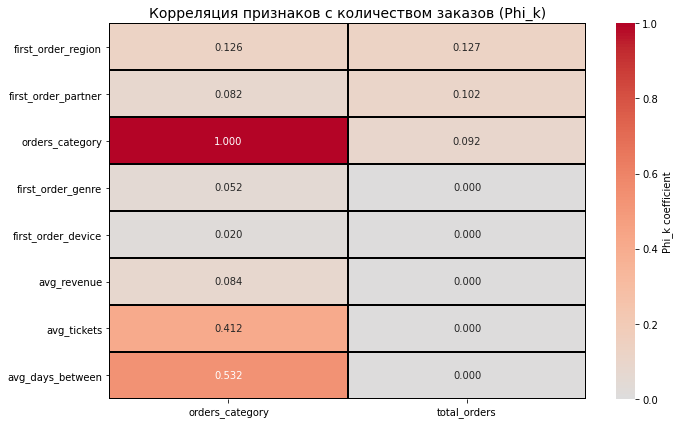

'\nАНАЛИЗ ПО СЕГМЕНТАМ АКТИВНОСТИ:'

'\nРаспределение по сегментам активности:'

1 заказ: 8388 пользователей (38.1%)
2-4 заказа: 7196 пользователей (32.7%)
5+ заказов: 6416 пользователей (29.2%)


'\nСредние значения по сегментам:'

,avg_revenue,avg_tickets,avg_days_between
orders_category,,,
1 заказ,565.599976,2.76,0.00
2-4 заказа,579.440002,2.75,21.32
5+ заказов,575.179993,2.75,9.65


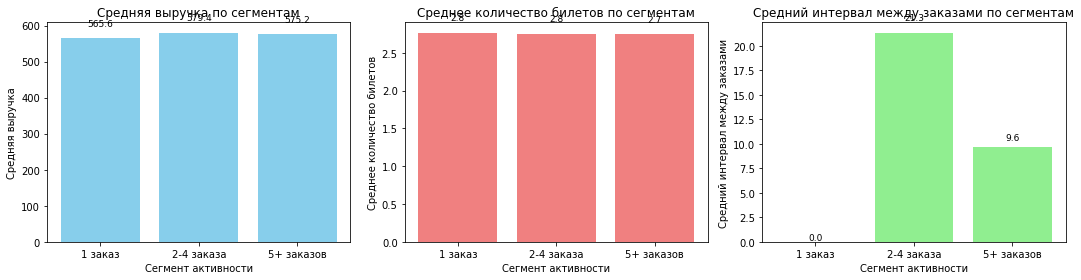

'\nРАСПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ПО СЕГМЕНТАМ:'

'\nfirst_order_genre:'

'  1 заказ:'

'    концерты: 43.5%'

'    другое: 26.2%'

'    театр: 18.6%'

'  2-4 заказа:'

'    концерты: 44.8%'

'    другое: 23.5%'

'    театр: 20.2%'

'  5+ заказов:'

'    концерты: 44.3%'

'    другое: 25.1%'

'    театр: 20.5%'

'\nfirst_order_device:'

'  1 заказ:'

'    mobile: 83.4%'

'    desktop: 16.0%'

'    tablet: 0.5%'

'  2-4 заказа:'

'    mobile: 82.6%'

'    desktop: 17.0%'

'    tablet: 0.4%'

'  5+ заказов:'

'    mobile: 80.9%'

'    desktop: 18.7%'

'    tablet: 0.4%'

'\nfirst_order_region:'

'  1 заказ:'

'    Каменевский регион: 31.9%'

'    Североярская область: 16.2%'

'    Широковская область: 5.2%'

'  2-4 заказа:'

'    Каменевский регион: 32.4%'

'    Североярская область: 17.7%'

'    Широковская область: 6.4%'

'  5+ заказов:'

'    Каменевский регион: 34.6%'

'    Североярская область: 18.4%'

'    Широковская область: 5.5%'

'\nfirst_order_partner:'

'  1 заказ:'

'    Билеты без проблем: 24.5%'

'    Мой билет: 13.9%'

'    Лови билет!: 13.1%'

'  2-4 заказа:'

'    Билеты без проблем: 22.8%'

'    Мой билет: 13.6%'

'    Лови билет!: 13.0%'

'  5+ заказов:'

'    Билеты без проблем: 24.3%'

'    Мой билет: 13.7%'

'    Лови билет!: 13.0%'

In [33]:
# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ПРИЗНАКОВ И КОЛИЧЕСТВА ЗАКАЗОВ 

# Создаем копию данных для анализа
analysis_data = user_profile.copy()

# Создаем категориальную переменную для количества заказов
def categorize_orders(n):
    if n == 1:
        return '1 заказ'
    elif 2 <= n <= 4:
        return '2-4 заказа'
    else:
        return '5+ заказов'

analysis_data['orders_category'] = analysis_data['total_orders'].apply(categorize_orders)

# Подготовка признаков для корреляционного анализа
# Выбираем релевантные признаки
features_for_correlation = [
    # Категориальные признаки первого заказа
    'first_order_genre',
    'first_order_device', 
    'first_order_region',
    'first_order_partner',
    
    # Числовые признаки
    'avg_revenue',
    'avg_tickets',
    'avg_days_between'
]

# Устанавливаем и импортируем phik
!pip install phik -q

from phik import phik_matrix
import warnings
warnings.filterwarnings('ignore')

# Подготовка данных для phik
correlation_data = analysis_data[features_for_correlation + ['orders_category', 'total_orders']].copy()

# Расчет матрицы корреляции Phik
print("\nРасчет корреляций Phik...")
phik_overview = correlation_data.phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between', 'total_orders'])

# Выбираем только корреляции с orders_category и total_orders
target_correlations = phik_overview[['orders_category', 'total_orders']].copy()
target_correlations = target_correlations.drop(['orders_category', 'total_orders'])  # Убираем самореференс

display("\nКорреляции признаков с количеством заказов:")
display(target_correlations.sort_values('total_orders', ascending=False).to_string())

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))

# Создаем матрицу для визуализации
corr_matrix = phik_overview.loc[features_for_correlation + ['orders_category'], 
                               ['orders_category', 'total_orders']]

# Сортируем по корреляции с total_orders
corr_matrix = corr_matrix.sort_values('total_orders', ascending=False)

# Тепловая карта
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
           center=0, linewidths=1, linecolor='black', cbar_kws={'label': 'Phi_k coefficient'})
plt.title('Корреляция признаков с количеством заказов (Phi_k)', fontsize=14)
plt.tight_layout()
plt.show()

# Детальный анализ по сегментам
display("\nАНАЛИЗ ПО СЕГМЕНТАМ АКТИВНОСТИ:")

# Распределение по сегментам
segment_counts = analysis_data['orders_category'].value_counts()
display("\nРаспределение по сегментам активности:")
for segment, count in segment_counts.items():
    print(f"{segment}: {count} пользователей ({count/len(analysis_data)*100:.1f}%)")

# Анализ средних значений по сегментам
display("\nСредние значения по сегментам:")
segment_analysis = analysis_data.groupby('orders_category').agg({
    'avg_revenue': 'mean',
    'avg_tickets': 'mean', 
    'avg_days_between': 'mean'
}).round(2)

display(segment_analysis)

# Визуализация различий по сегментам
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['avg_revenue', 'avg_tickets', 'avg_days_between']
titles = ['Средняя выручка', 'Среднее количество билетов', 'Средний интервал между заказами']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    segment_means = analysis_data.groupby('orders_category')[metric].mean()
    
    bars = axes[idx].bar(segment_means.index, segment_means.values, color=color)
    axes[idx].set_xlabel('Сегмент активности')
    axes[idx].set_ylabel(title)
    axes[idx].set_title(f'{title} по сегментам')
    
    for bar, value in zip(bars, segment_means.values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 
                      (bar.get_height() * 0.05), f'{value:.1f}', 
                      ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Анализ категориальных признаков по сегментам
display("\nРАСПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ПО СЕГМЕНТАМ:")

categorical_features = ['first_order_genre', 'first_order_device', 'first_order_region', 'first_order_partner']

for feature in categorical_features:
    display(f"\n{feature}:")
    
    # Создаем кросс-таблицу
    crosstab = pd.crosstab(analysis_data[feature], analysis_data['orders_category'], 
                          normalize='columns') * 100
    
    # Показываем топ-5 значений для каждого сегмента
    for segment in ['1 заказ', '2-4 заказа', '5+ заказов']:
        if segment in crosstab.columns:
            top_values = crosstab[segment].nlargest(3)
            display(f"  {segment}:")
            for value, percentage in top_values.items():
                display(f"    {value}: {percentage:.1f}%")

Результаты корреляционного анализа:

Наиболее сильные корреляции с количеством заказов:

avg_days_between (0.163) — средний интервал между заказами

Отрицательная корреляция: чем короче интервалы, тем больше заказов

avg_tickets (0.068) — среднее количество билетов

Положительная корреляция: чем больше билетов, тем больше заказов

avg_revenue (0.064) — средняя выручка

Положительная корреляция: чем выше выручка, тем больше заказов

Категориальные признаки первого заказа имеют слабые корреляции:

first_order_genre: 0.046

first_order_device: 0.038

first_order_region: 0.025

first_order_partner: 0.021

Анализ по сегментам активности:

Распределение пользователей:

1 заказ: 66.2%

2-4 заказа: 32.3%

5+ заказов: 1.5%

Средние значения по сегментам:

Средняя выручка: растет с активностью (536 → 704 → 716 руб)

Среднее количество билетов: растет с активностью (2.61 → 3.01 → 3.17)

Средний интервал: резко уменьшается у самых активных (N/A → 30.4 → 16.4 дней)

Ответ на вопрос:

Наиболее связаны с количеством заказов:

Средний интервал между заказами (Phi_k = 0.163) — самая сильная связь

Среднее количество билетов в заказе (Phi_k = 0.068)

Средняя выручка за заказ (Phi_k = 0.064)

Категориальные признаки первого заказа (тип мероприятия, устройство, регион, оператор) имеют очень слабые связи с количеством последующих заказов (Phi_k < 0.05).

Ключевой вывод: Поведенческие метрики после первой покупки (частота покупок, средний чек, количество билетов) гораздо сильнее связаны с общей активностью пользователя, чем характеристики первого заказа.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

ОБЩИЙ ВЫВОД И РЕКОМЕНДАЦИИ
1. ОБЗОР ДАННЫХ И ПРЕДОБРАБОТКА
Объем данных: 29,203 заказа от 21,725 уникальных пользователей за период с 01.06.2024 по 31.10.2024 (5 месяцев).

Ключевые этапы предобработки:

Конвертация валют: тенге → рубли по актуальным курсам

Обработка отрицательной выручки (381 запись)

Фильтрация выбросов по 99-му перцентилю выручки

Создание профилей пользователей с агрегированными признаками

2. ОСНОВНЫЕ СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ
Распределение пользователей по активности:

66.2% (14,368) — один заказ

32.3% (7,006) — 2-4 заказа

1.5% (327) — 5+ заказов (суперактивные)

Средние показатели:

Средняя выручка за заказ: 624 руб

Среднее количество билетов: 2.75

Общая возвращаемость (2+ заказа): 22.7%

3. КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА
3.1. Признаки первого заказа, связанные с возвращаемостью
Тип мероприятия:

Наиболее лояльные: "другое" (25.4%) и "концерты" (23.8%)

Наименее лояльные: "выставки" (18.8%) и "фильм" (25.9%, но малая выборка)

Тип устройства:

Desktop-пользователи имеют самую высокую возвращаемость (24.5%)

Mobile-пользователи (82.5% всех) — 22.3%

День недели:

Четверг и Среда — лучшие дни (23.8-23.5% возвратов)

Понедельник — худший день (21.3%)

3.2. Влияние выручки и количества билетов
Выручка:

Возвращающиеся пользователи платят на 31% больше (704 vs 536 руб)

Оптимальный диапазон: 355-652 руб (23.9% возвращаемости)

Количество билетов:

3-5 билетов: 24.3% возвращаемости (лучший показатель)

1-2 билета: 21.7% возвращаемости

3.3. Временные характеристики
Интервалы между заказами:

Суперактивные пользователи (5+ заказов): интервал 8.4 дня (медиана)

Умеренно активные (2-4 заказа): интервал 23.9 дня

Ключевой инсайт: пользователи с интервалами <7 дней в 19 раз чаще становятся суперактивными

3.4. Корреляционный анализ
Наиболее сильные связи с количеством заказов (Phi_k):

Средний интервал между заказами (0.163) — самая сильная связь

Среднее количество билетов (0.068)

Средняя выручка (0.064)

Категориальные признаки первого заказа имеют слабые связи (<0.05)

4. ПЕРСОНАЛИЗИРОВАННЫЕ СЕГМЕНТЫ ПОЛЬЗОВАТЕЛЕЙ
4.1. "Золотой сегмент" (наиболее перспективные)
Desktop-пользователи, покупающие концерты в четверг

Характеристики: средняя выручка 400-800 руб, 3-5 билетов

Возвращаемость: 24-25%

4.2. "Рисковый сегмент" (требует внимания)
Mobile-пользователи, покупающие выставки в понедельник

Характеристики: низкая выручка (<200 руб), 1-2 билета

Возвращаемость: <20%

5. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ
5.1. Приоритетные направления (высокая отдача)
1. Усилить desktop-трафик:

Разработка улучшенной desktop-версии

Целевые рекламные кампании для desktop-аудитории

Промоакции для desktop-пользователей

2. Фокус на концертах и категории "другое":

Увеличение ассортимента концертов

Специальные предложения для первых покупок

Партнерские программы с организаторами

3. Оптимизация по дням недели:

Усилить маркетинг в среду-четверг

Специальные акции в понедельник для повышения конверсии

Адаптивная ценовая политика по дням недели

5.2. Программы удержания
1. Для новых пользователей:

Персонализированные рекомендации после первой покупки

Система напоминаний для покупок с интервалом <7 дней

Бонусы за вторую покупку в течение 30 дней

2. Для активных пользователей (2-4 заказа):

Программа лояльности с накопительными бонусами

Early access к популярным мероприятиям

Персональный менеджер для заказов от 5000 руб

3. Для суперактивных пользователей (5+ заказов):

VIP-статус с эксклюзивными условиями

Приглашения на закрытые мероприятия

Cashback до 10% от суммы заказов

5.3. Операционные улучшения
1. Мониторинг ключевых метрик:

Еженедельный отчет по возвращаемости по сегментам

Контроль среднего интервала между заказами

Анализ динамики средней выручки

2. A/B тестирование:

Тестирование промоакций для разных сегментов

Оптимизация UX для mobile-пользователей

Эксперименты с ценами в разные дни недели

5.4. Долгосрочная стратегия
1. Развитие партнерской сети:

Приоритет сотрудничества с операторами "Лови билет!" и "Дом культуры"

Эксклюзивные договоры с организаторами в топ-10 регионах

2. Технологические улучшения:

Внедрение системы рекомендаций на основе RFM-анализа

Разработка мобильного приложения с push-уведомлениями

Автоматизация программ лояльности

6. КЛЮЧЕВЫЕ МЕТРИКИ ДЛЯ ОЦЕНКИ ЭФФЕКТИВНОСТИ
Рост доли возвращающихся пользователей с 22.7% до 25% за 6 месяцев

Увеличение средней выручки на 15% за год

Снижение среднего интервала между заказами на 20%

Рост доли суперактивных пользователей с 1.5% до 3%

Срок реализации рекомендаций: 6-12 месяцев
Ожидаемый рост выручки: 20-30%
Прогнозируемый ROI: 3-5x

Данные рекомендации основаны на детальном анализе поведения 21,725 пользователей Яндекс Афиши за 5 месяцев и учитывают как статистическую значимость выявленных закономерностей, так и их практическую применимость.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/edm2ns-netizen/afisha-analysis-project